In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR100, CIFAR10
from continuum.tasks import split_train_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR10("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=2,  # Add 2 new classes per task
    initial_increment=2  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class NN(nn.Module):
    def __init__(self, layer_sizes):
        super(NN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            m = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            self.linears.append(m)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0).to(device))  # Add batch dimension and move to GPU
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize, device=device)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk.cpu().numpy()  # Move NTK matrix back to CPU for plotting

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)  # Move data to GPU
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Lists to store fixed samples and validation tasksets
fixed_train_samples = []
fixed_val_samples = []
val_tasksets = []
train_tasksets = []

# Function to extract fixed samples and validation tasksets
def extract_fixed_samples_and_tasksets(scenario):
    for task_id, train_taskset in enumerate(scenario):
        # Split the taskset into training and validation sets
        train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
        
        # Store fixed samples for NTK calculation
        fixed_train_samples.append([train_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        fixed_val_samples.append([val_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        
        # Store validation taskset
        val_tasksets.append(val_taskset)
        train_tasksets.append(train_taskset)

# Function to train, evaluate, and plot NTK metrics
def train_and_evaluate(model, epochs_per_task):
    num_tasks = len(val_tasksets)
    total_epochs = num_tasks * epochs_per_task

    # Initialize lists to store results
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    task_accuracies = [[] for _ in range(num_tasks)]  # Accuracy on all tasks after each epoch
    train_ntk_matrices = [[] for _ in range(num_tasks)]
    test_ntk_matrices = [[] for _ in range(num_tasks)]

    # Train and evaluate on each task
    for task_id in range(num_tasks):
        print(f"\n=== Task {task_id + 1} ===")
        
        train_loader = DataLoader(train_tasksets[task_id], batch_size=32, shuffle=True)
        val_loader = DataLoader(val_tasksets[task_id], batch_size=32, shuffle=False)
        
        # Train the model on the current task
        model.train()
        for epoch in range(epochs_per_task):
            global_epoch = task_id * epochs_per_task + epoch  # Global epoch index
            running_loss = 0.0
            running_accuracy = 0.0
            correct = 0
            total = 0
            for x, y, t in train_loader:
                x, y = x.to(device), y.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct += (pred == y).sum().item()
                total += y.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Evaluate on the validation set
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {global_epoch + 1}, "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Calculate NTK for fixed samples at the end of each epoch
            model.eval()
            for t in range(task_id + 1):
                train_ntk = simrnn_ntk(fixed_train_samples[t], model)
                test_ntk = simrnn_ntk(fixed_val_samples[t], model)
                train_ntk_matrices[t].append(train_ntk)
                test_ntk_matrices[t].append(test_ntk)

            # Evaluate the model on all tasks seen so far using fixed validation sets
            for t in range(task_id + 1):
                val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
                _, accuracy = evaluate(model, val_loader_t, criterion)
                task_accuracies[t].append(accuracy)
                print(f"Accuracy on Task {t + 1} at Epoch {global_epoch + 1}: {accuracy:.4f}")

    # # Function to calculate NTK norms, max eigenvalue, and min eigenvalue
    # def calculate_ntk_metrics(ntk_matrices):
    #     norms = []
    #     max_eigenvalues = []
    #     min_eigenvalues = []
    #     for task_ntk_matrices in ntk_matrices:
    #         task_norms = []
    #         task_max_eigenvalues = []
    #         task_min_eigenvalues = []
    #         for ntk_matrix in task_ntk_matrices:
    #             task_norms.append(torch.norm(ntk_matrix, p='fro').item())
    #             eigenvalues = torch.linalg.eigvalsh(ntk_matrix)
    #             task_max_eigenvalues.append(eigenvalues[-1].item())
    #             task_min_eigenvalues.append(eigenvalues[0].item())
    #         norms.append(task_norms)
    #         max_eigenvalues.append(task_max_eigenvalues)
    #         min_eigenvalues.append(task_min_eigenvalues)
        # return norms, max_eigenvalues, min_eigenvalues
    def calculate_ntk_metrics(ntk_matrices):
        norms = []
        max_eigenvalues = []
        min_eigenvalues = []
        for task_ntk_matrices in ntk_matrices:
            task_norms = []
            task_max_eigenvalues = []
            task_min_eigenvalues = []
            for ntk_matrix in task_ntk_matrices:
                task_norms.append(np.linalg.norm(ntk_matrix, ord='fro'))  # Use numpy.linalg.norm
                eigenvalues = np.linalg.eigvalsh(ntk_matrix)  # Use numpy.linalg.eigvalsh
                task_max_eigenvalues.append(eigenvalues[-1])
                task_min_eigenvalues.append(eigenvalues[0])
            norms.append(task_norms)
            max_eigenvalues.append(task_max_eigenvalues)
            min_eigenvalues.append(task_min_eigenvalues)
        return norms, max_eigenvalues, min_eigenvalues

    # Calculate NTK metrics for train and test NTK matrices
    train_ntk_norms, train_ntk_max_eigenvalues, train_ntk_min_eigenvalues = calculate_ntk_metrics(train_ntk_matrices)
    test_ntk_norms, test_ntk_max_eigenvalues, test_ntk_min_eigenvalues = calculate_ntk_metrics(test_ntk_matrices)

    # Function to plot NTK metrics
#     def plot_ntk_metrics(ntk_metrics, title, ylabel):
#         plt.figure(figsize=(10, 6))
#         colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_metrics)))  # Assign a color to each task

#         for t in range(len(ntk_metrics)):
#             # Extract NTK metrics for Task t's dataset
#             ntk_metrics_task = ntk_metrics[t]
            
#             # The x-axis starts from the epoch when the task was introduced
#             x_values = range(t * epochs_per_task, total_epochs)
#             y_values = ntk_metrics_task
            
#             # Plot the curve for Task t's dataset
#             plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

#         plt.xlabel('Epoch')
#         plt.ylabel(ylabel)
#         plt.title(title)
#         plt.legend()
#         plt.grid(True)
#         plt.show()
        
    def plot_ntk_metrics(ntk_metrics, title, ylabel):
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_metrics)))  # Assign a color to each task

        for t in range(len(ntk_metrics)):
            # Extract NTK metrics for Task t's dataset
            ntk_metrics_task = ntk_metrics[t]

            # The x-axis starts from the epoch when the task was introduced
            x_values = range(t * epochs_per_task, total_epochs)
            y_values = ntk_metrics_task

            # Plot the curve for Task t's dataset
            plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

        # Customize x-axis ticks and labels
        xticks = np.arange(0, total_epochs, epochs_per_task)  # Set ticks at the start of each task
        xticklabels = [f"Task {i}" for i in range(len(xticks))]  # Label ticks as Task 0, Task 1, etc.
        plt.xticks(xticks, xticklabels)  # Apply custom ticks and labels

        plt.xlabel('Task')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot NTK norms
    plot_ntk_metrics(train_ntk_norms, title='Train NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Norm')
    plot_ntk_metrics(test_ntk_norms, title='Test NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Norm')

    # Plot NTK max eigenvalues
    plot_ntk_metrics(train_ntk_max_eigenvalues, title='Train NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Max Eigenvalue')
    plot_ntk_metrics(test_ntk_max_eigenvalues, title='Test NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Max Eigenvalue')

    # Plot NTK min eigenvalues
    plot_ntk_metrics(train_ntk_min_eigenvalues, title='Train NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Min Eigenvalue')
    plot_ntk_metrics(test_ntk_min_eigenvalues, title='Test NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Min Eigenvalue')

    # Plot task accuracies
    plot_ntk_metrics(task_accuracies, title='Test Accuracy for Each Task\'s Dataset Across Epochs', ylabel='Test Accuracy')

    return train_ntk_matrices, test_ntk_matrices, task_accuracies

# Example usage:
# First, extract fixed samples and tasksets
extract_fixed_samples_and_tasksets(scenario)

# # Then, define your model and train it
# layer_sizes = [32 * 32 * 3] + [100] * 3 + [10] #100
# model = NN(layer_sizes).to(device)  # Move model to GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# epochs_per_task = 2

# # Train and evaluate the model
# train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate(model, epochs_per_task)

Using device: cuda
Files already downloaded and verified
Number of classes: 10.
Number of tasks: 5.



=== Task 1 ===
Epoch 1, Train Loss: 0.6054, Val Loss: 0.4176, Train Accuracy: 0.7827, Val Accuracy: 0.8070
Accuracy on Task 1 at Epoch 1: 0.8070
Epoch 2, Train Loss: 0.4152, Val Loss: 0.4082, Train Accuracy: 0.8132, Val Accuracy: 0.8160
Accuracy on Task 1 at Epoch 2: 0.8160
Epoch 3, Train Loss: 0.3861, Val Loss: 0.4000, Train Accuracy: 0.8284, Val Accuracy: 0.8190
Accuracy on Task 1 at Epoch 3: 0.8190
Epoch 4, Train Loss: 0.3705, Val Loss: 0.3565, Train Accuracy: 0.8347, Val Accuracy: 0.8510
Accuracy on Task 1 at Epoch 4: 0.8510
Epoch 5, Train Loss: 0.3580, Val Loss: 0.3705, Train Accuracy: 0.8354, Val Accuracy: 0.8340
Accuracy on Task 1 at Epoch 5: 0.8340
Epoch 6, Train Loss: 0.3508, Val Loss: 0.3712, Train Accuracy: 0.8473, Val Accuracy: 0.8210
Accuracy on Task 1 at Epoch 6: 0.8210
Epoch 7, Train Loss: 0.3305, Val Loss: 0.3745, Train Accuracy: 0.8552, Val Accuracy: 0.8350
Accuracy on Task 1 at Epoch 7: 0.8350
Epoch 8, Train Loss: 0.3310, Val Loss: 0.3671, Train Accuracy: 0.8541, Val

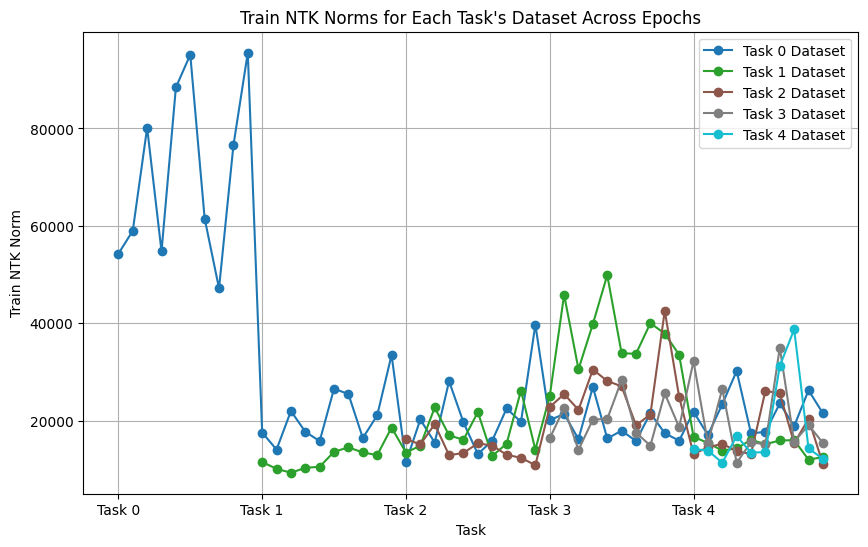

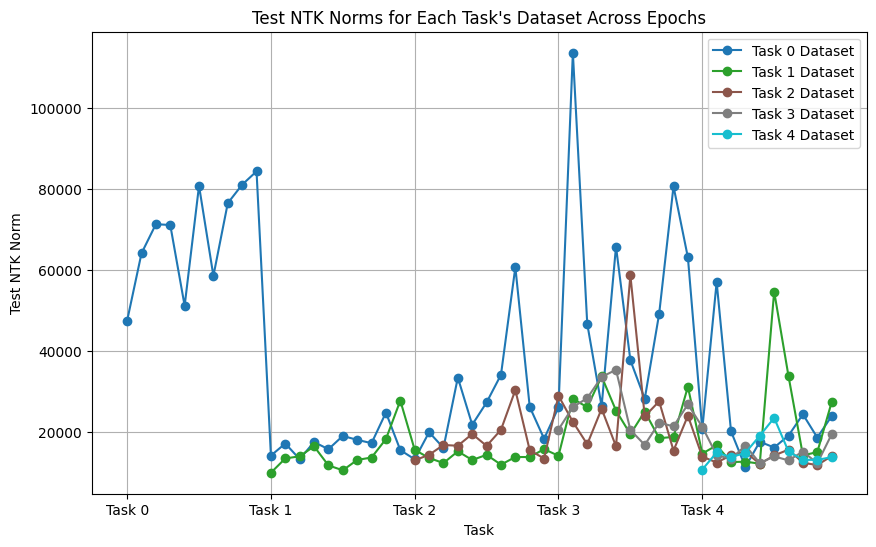

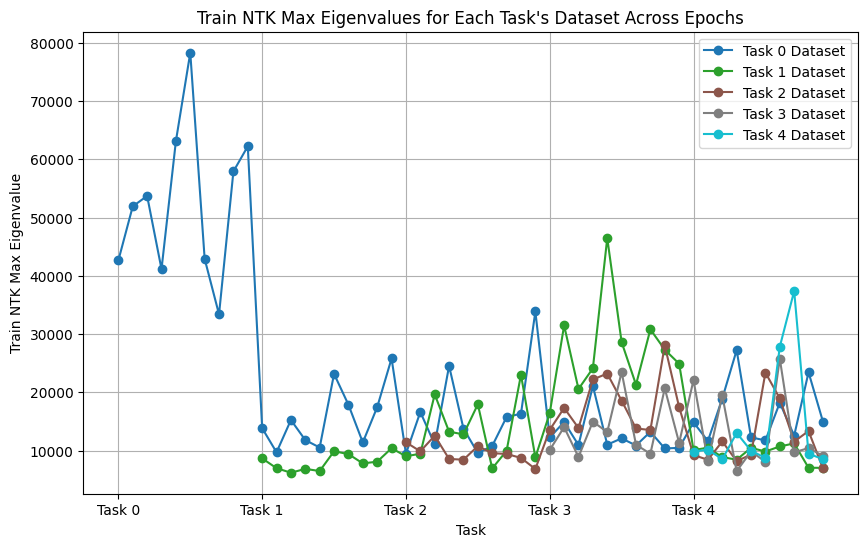

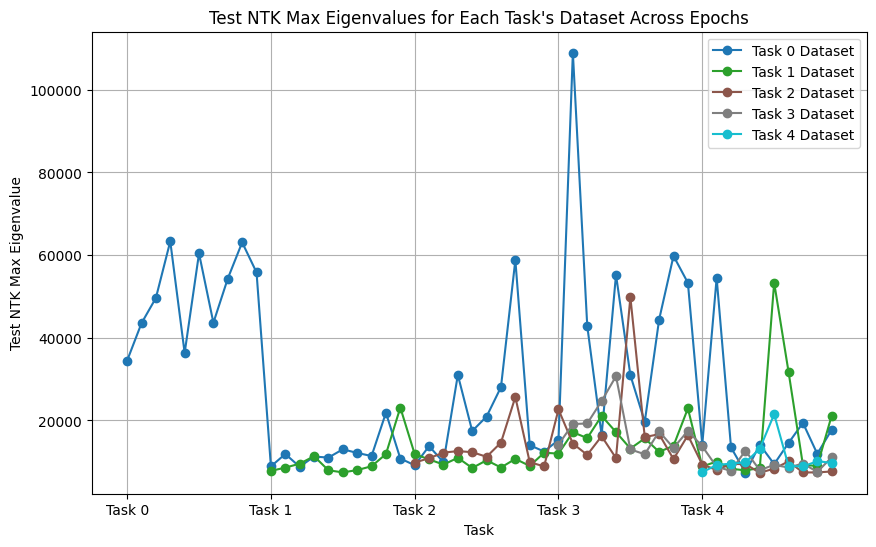

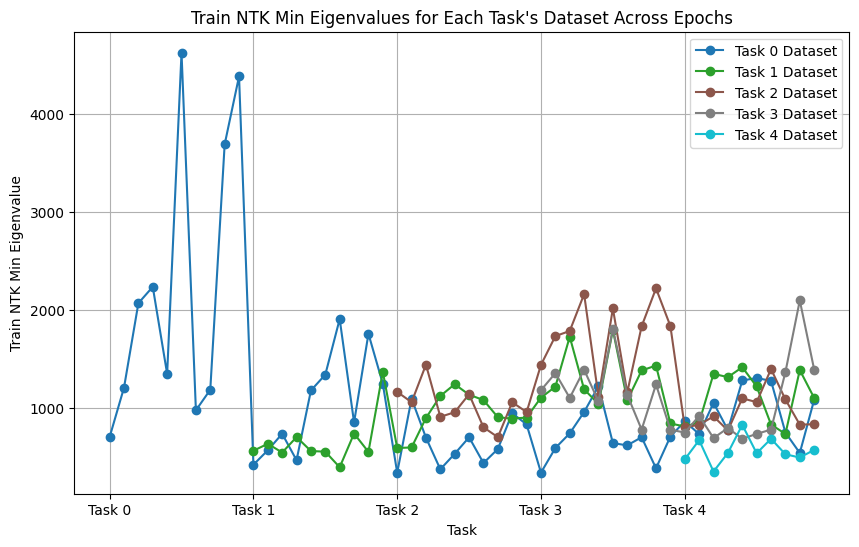

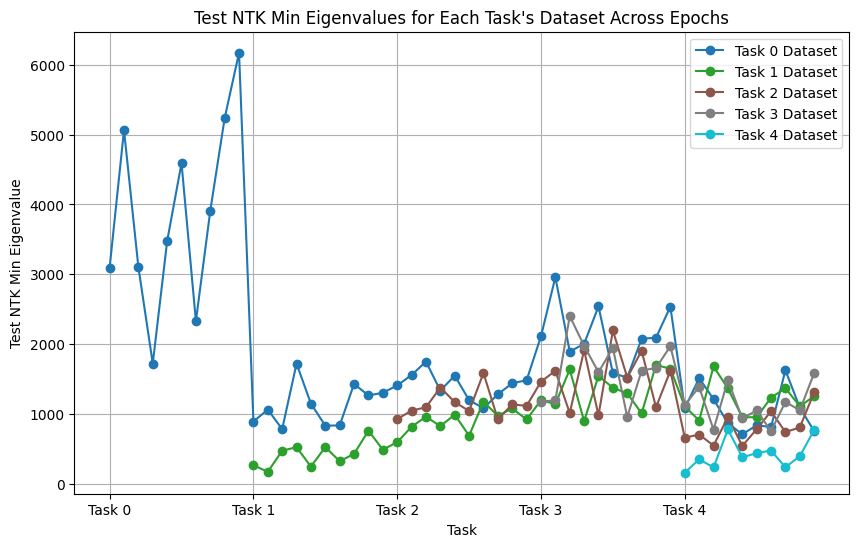

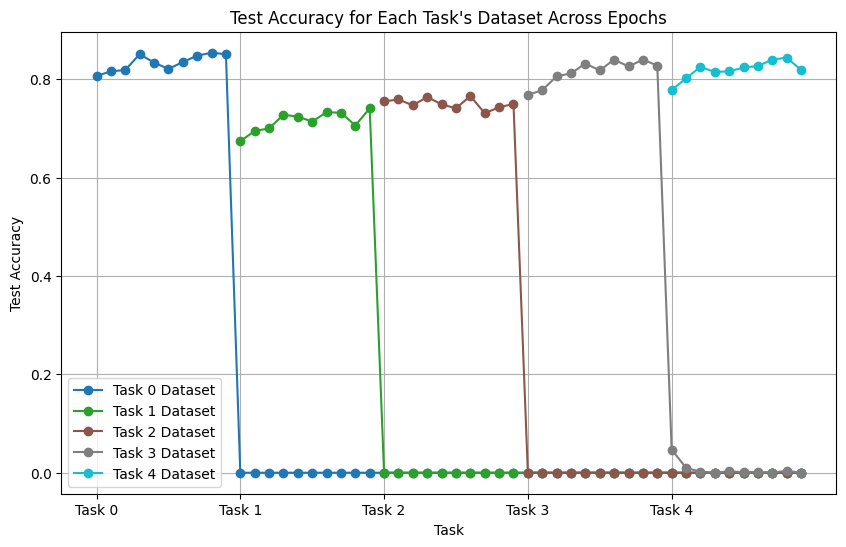


=== Task 1 ===
Epoch 1, Train Loss: 0.6150, Val Loss: 0.4569, Train Accuracy: 0.7793, Val Accuracy: 0.8210
Accuracy on Task 1 at Epoch 1: 0.8210
Epoch 2, Train Loss: 0.4389, Val Loss: 0.3634, Train Accuracy: 0.8123, Val Accuracy: 0.8420
Accuracy on Task 1 at Epoch 2: 0.8420
Epoch 3, Train Loss: 0.3910, Val Loss: 0.4167, Train Accuracy: 0.8250, Val Accuracy: 0.8410
Accuracy on Task 1 at Epoch 3: 0.8410
Epoch 4, Train Loss: 0.3755, Val Loss: 0.3717, Train Accuracy: 0.8371, Val Accuracy: 0.8430
Accuracy on Task 1 at Epoch 4: 0.8430
Epoch 5, Train Loss: 0.3703, Val Loss: 0.3896, Train Accuracy: 0.8398, Val Accuracy: 0.8360
Accuracy on Task 1 at Epoch 5: 0.8360
Epoch 6, Train Loss: 0.3477, Val Loss: 0.3919, Train Accuracy: 0.8522, Val Accuracy: 0.8350
Accuracy on Task 1 at Epoch 6: 0.8350
Epoch 7, Train Loss: 0.3429, Val Loss: 0.4767, Train Accuracy: 0.8503, Val Accuracy: 0.7810
Accuracy on Task 1 at Epoch 7: 0.7810
Epoch 8, Train Loss: 0.3623, Val Loss: 0.3409, Train Accuracy: 0.8479, Val

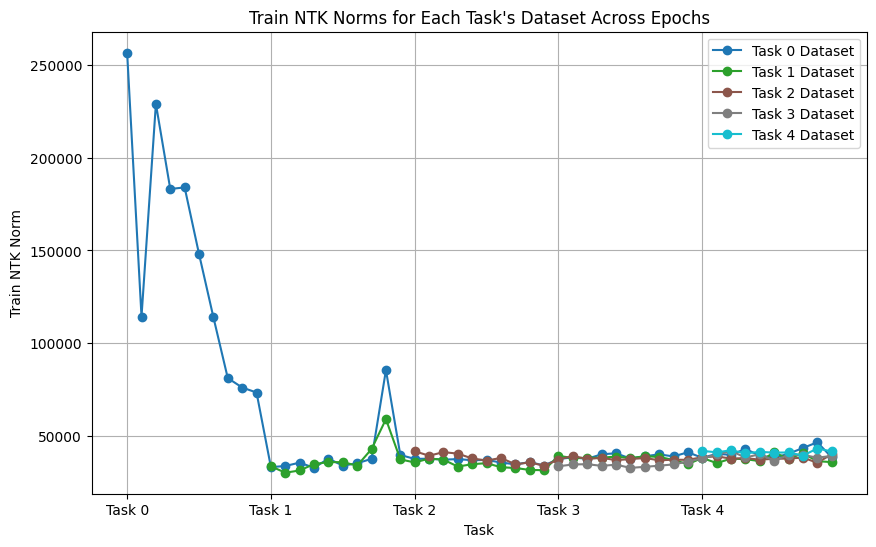

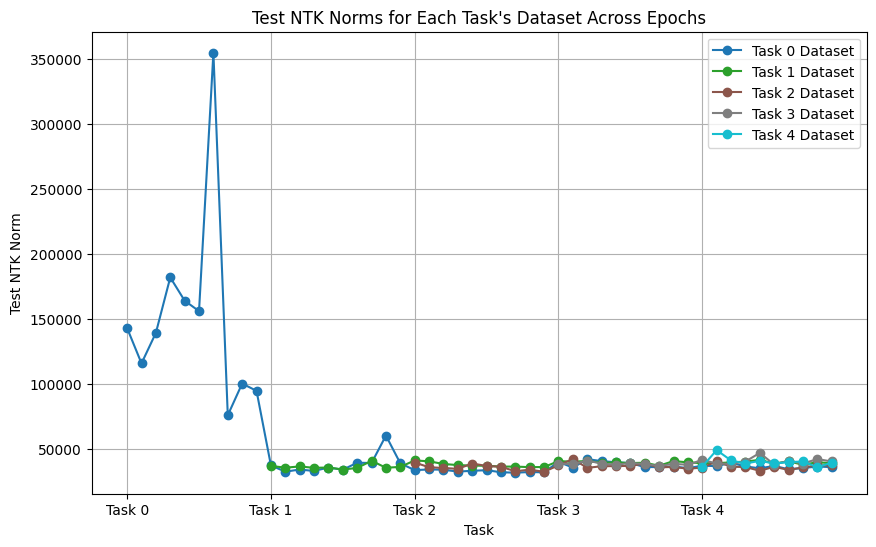

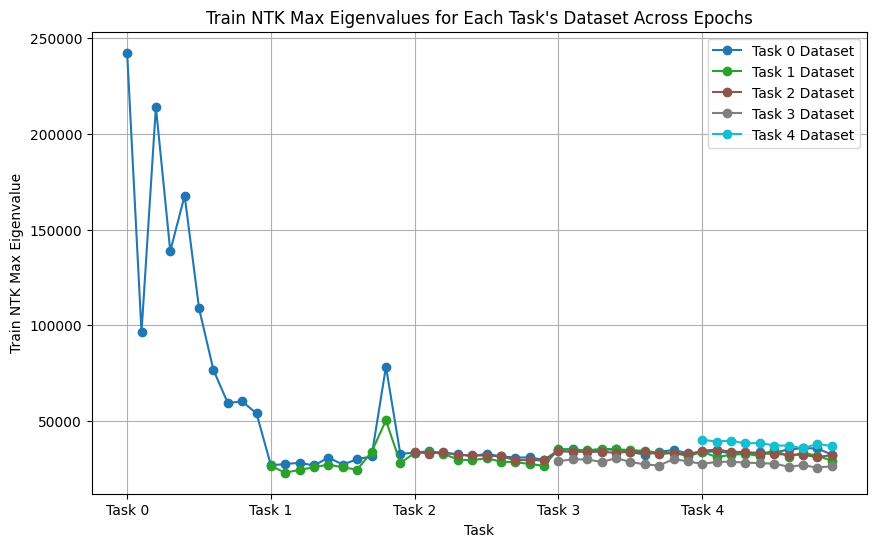

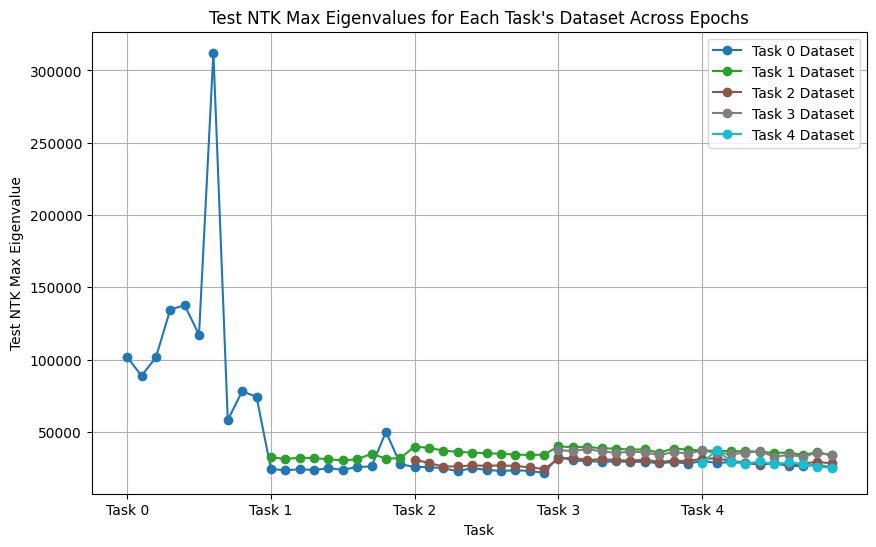

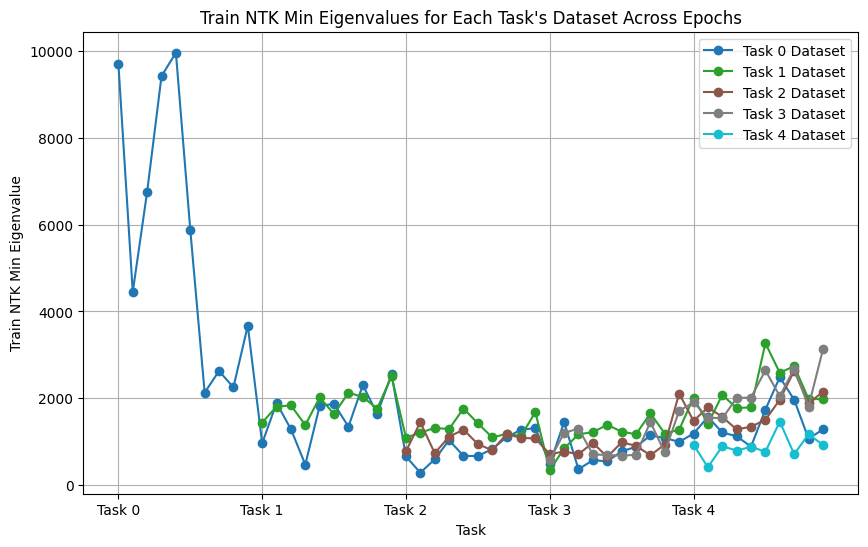

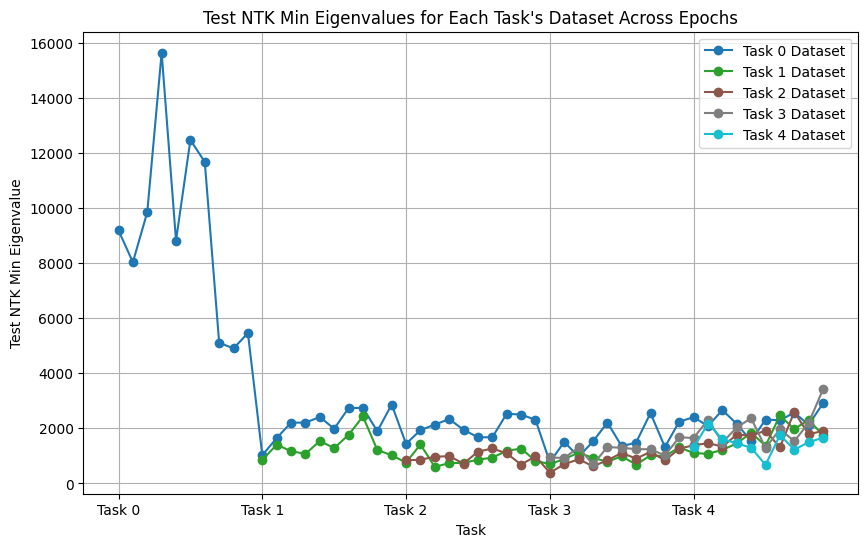

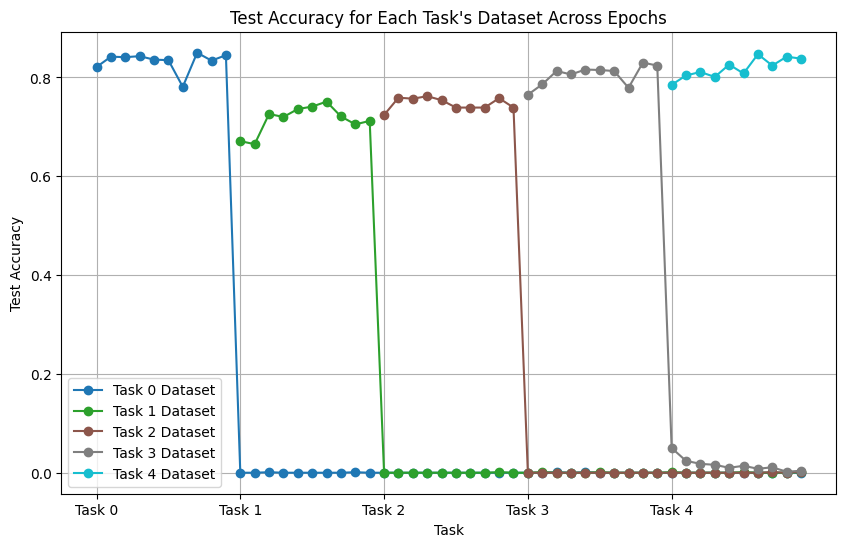


=== Task 1 ===
Epoch 1, Train Loss: 0.8611, Val Loss: 0.4520, Train Accuracy: 0.7450, Val Accuracy: 0.8220
Accuracy on Task 1 at Epoch 1: 0.8220
Epoch 2, Train Loss: 0.4721, Val Loss: 0.4806, Train Accuracy: 0.8023, Val Accuracy: 0.7930
Accuracy on Task 1 at Epoch 2: 0.7930
Epoch 3, Train Loss: 0.4146, Val Loss: 0.4054, Train Accuracy: 0.8166, Val Accuracy: 0.8320
Accuracy on Task 1 at Epoch 3: 0.8320
Epoch 4, Train Loss: 0.3970, Val Loss: 0.3804, Train Accuracy: 0.8290, Val Accuracy: 0.8270
Accuracy on Task 1 at Epoch 4: 0.8270
Epoch 5, Train Loss: 0.4044, Val Loss: 0.4442, Train Accuracy: 0.8356, Val Accuracy: 0.8080
Accuracy on Task 1 at Epoch 5: 0.8080
Epoch 6, Train Loss: 0.3693, Val Loss: 0.3568, Train Accuracy: 0.8401, Val Accuracy: 0.8480
Accuracy on Task 1 at Epoch 6: 0.8480
Epoch 7, Train Loss: 0.3487, Val Loss: 0.4632, Train Accuracy: 0.8456, Val Accuracy: 0.7790
Accuracy on Task 1 at Epoch 7: 0.7790
Epoch 8, Train Loss: 0.3545, Val Loss: 0.4558, Train Accuracy: 0.8468, Val

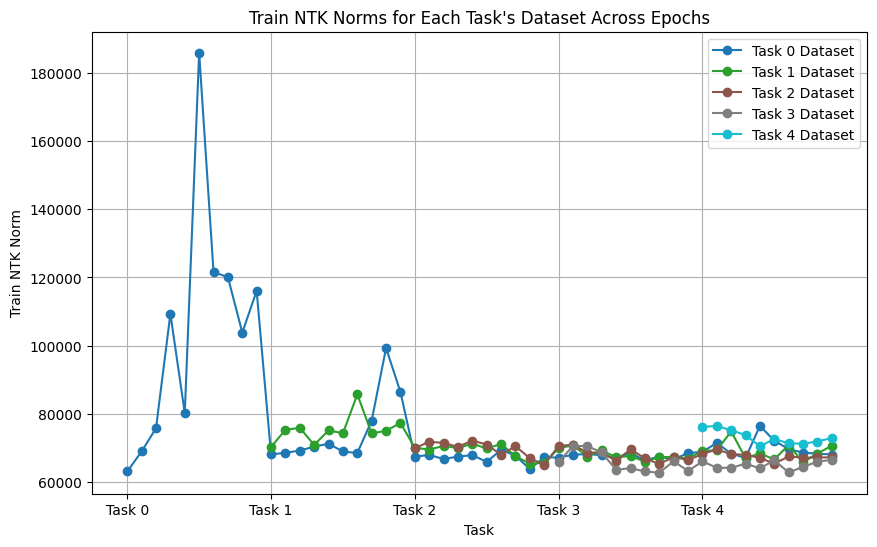

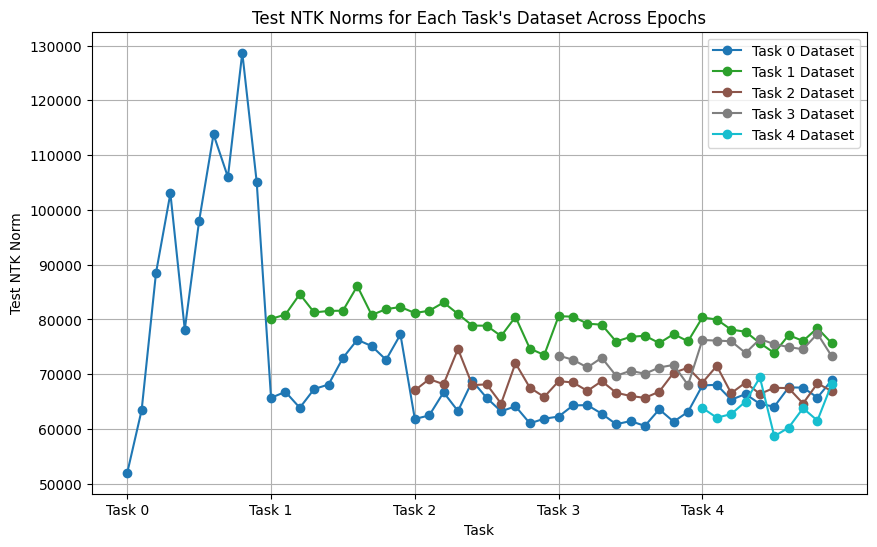

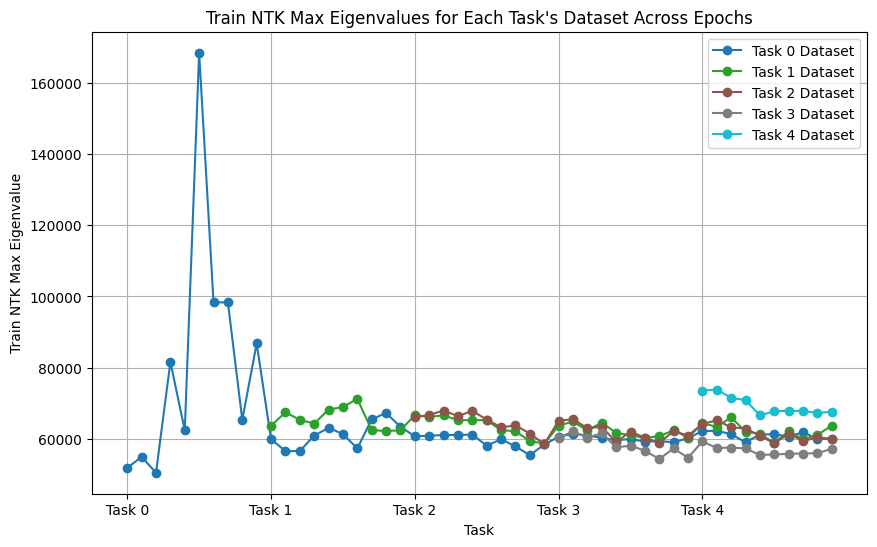

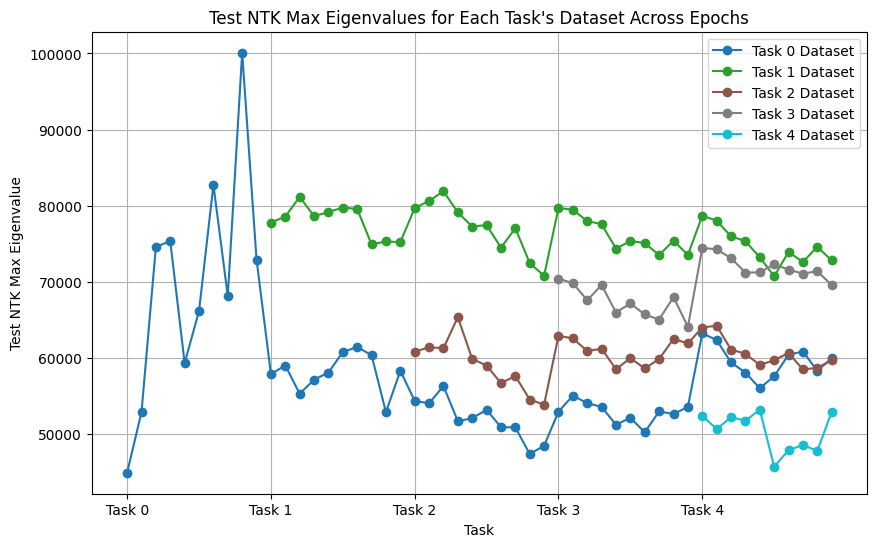

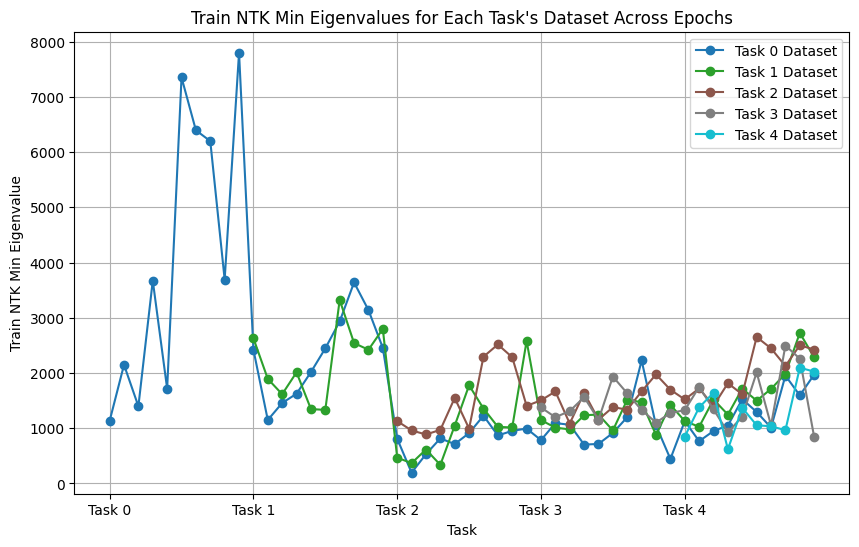

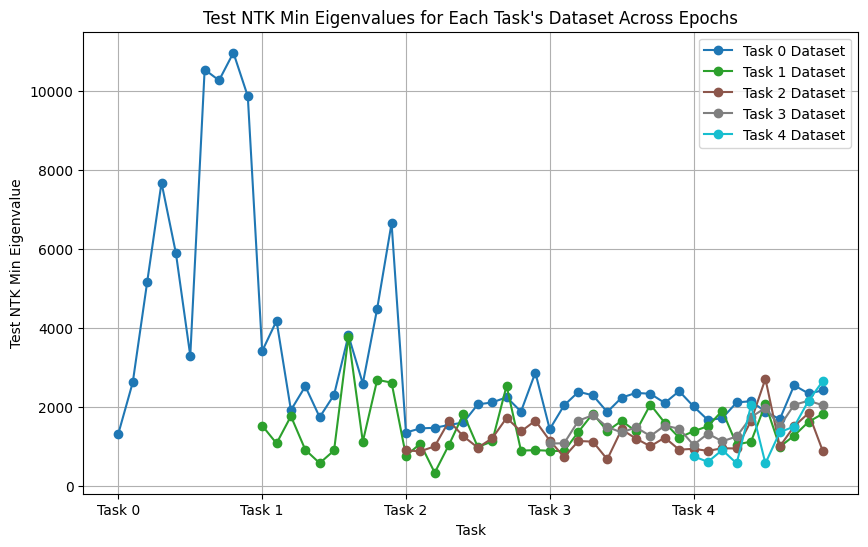

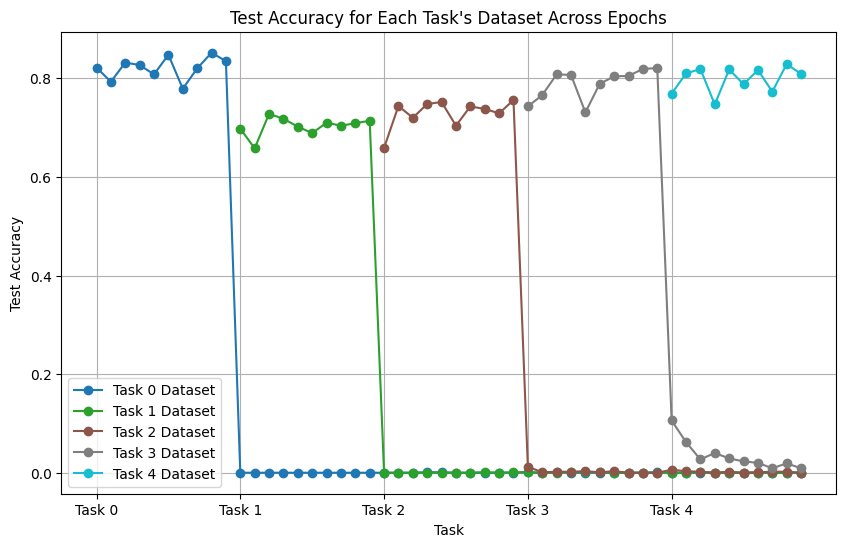


=== Task 1 ===
Epoch 1, Train Loss: 1.5382, Val Loss: 0.8945, Train Accuracy: 0.6834, Val Accuracy: 0.7660
Accuracy on Task 1 at Epoch 1: 0.7660
Epoch 2, Train Loss: 0.9268, Val Loss: 0.8912, Train Accuracy: 0.7547, Val Accuracy: 0.7310
Accuracy on Task 1 at Epoch 2: 0.7310
Epoch 3, Train Loss: 0.7997, Val Loss: 1.0091, Train Accuracy: 0.7710, Val Accuracy: 0.7350
Accuracy on Task 1 at Epoch 3: 0.7350
Epoch 4, Train Loss: 0.7466, Val Loss: 0.6231, Train Accuracy: 0.7728, Val Accuracy: 0.8120
Accuracy on Task 1 at Epoch 4: 0.8120
Epoch 5, Train Loss: 0.6272, Val Loss: 0.7563, Train Accuracy: 0.8001, Val Accuracy: 0.7670
Accuracy on Task 1 at Epoch 5: 0.7670
Epoch 6, Train Loss: 0.6023, Val Loss: 0.6405, Train Accuracy: 0.8006, Val Accuracy: 0.7800
Accuracy on Task 1 at Epoch 6: 0.7800
Epoch 7, Train Loss: 0.6063, Val Loss: 0.5463, Train Accuracy: 0.7910, Val Accuracy: 0.8210
Accuracy on Task 1 at Epoch 7: 0.8210
Epoch 8, Train Loss: 0.4988, Val Loss: 0.4915, Train Accuracy: 0.8158, Val

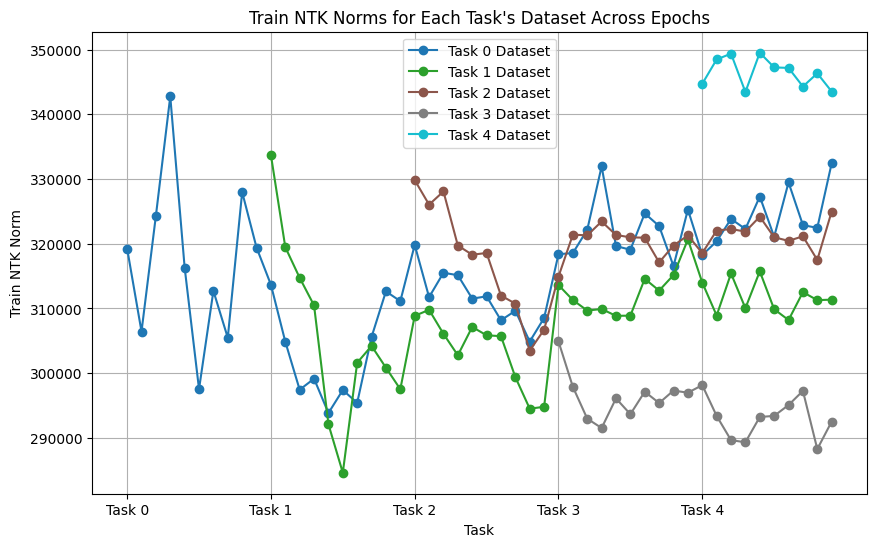

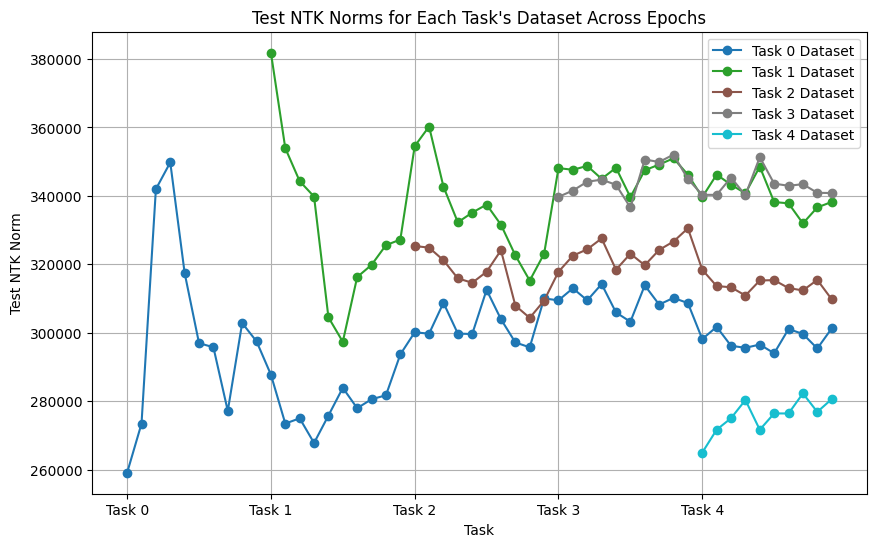

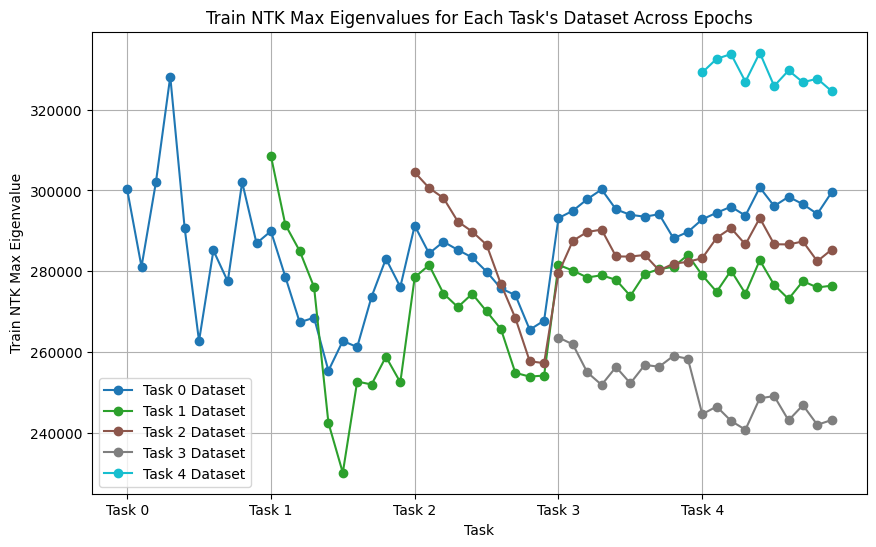

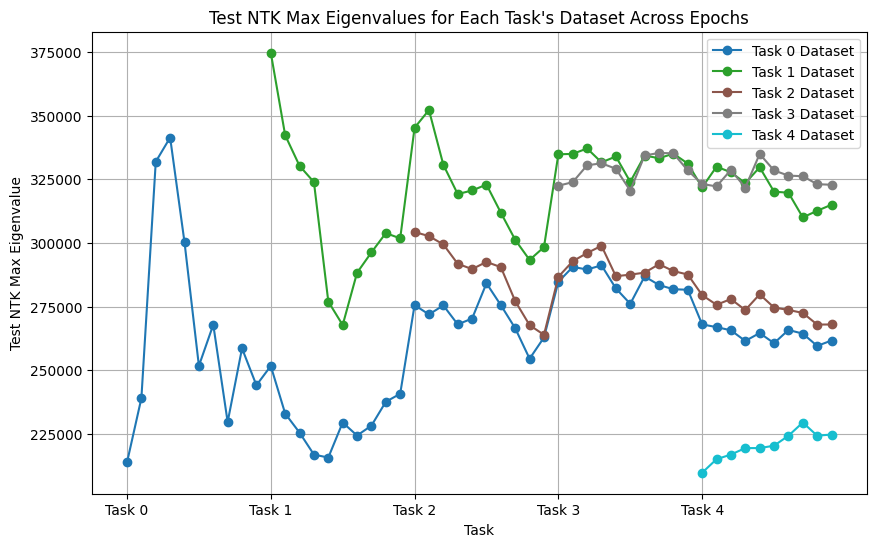

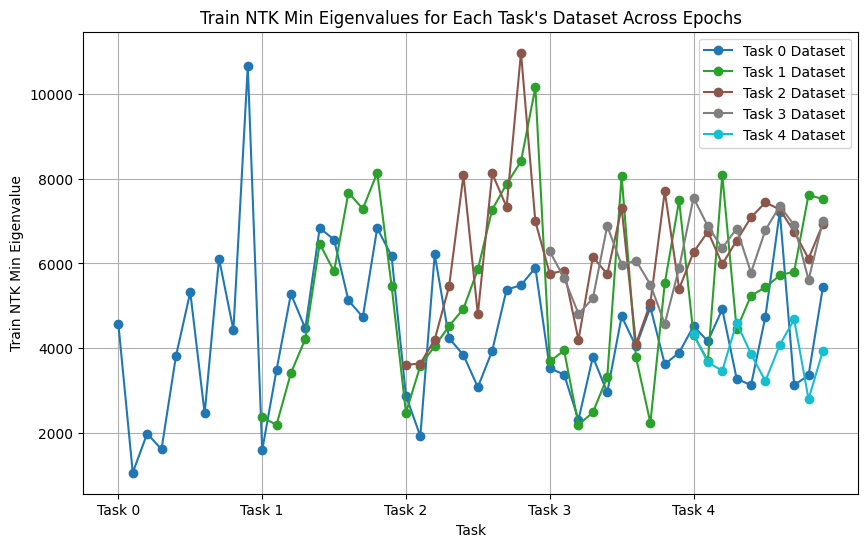

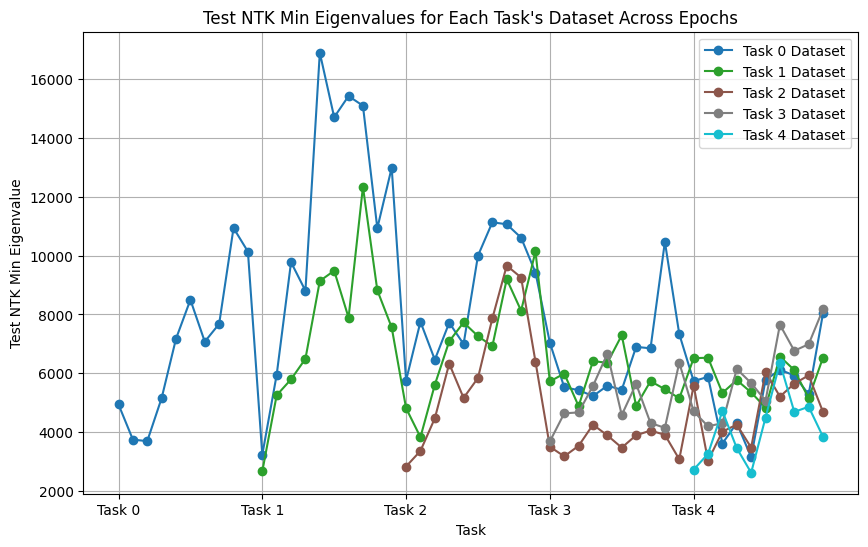

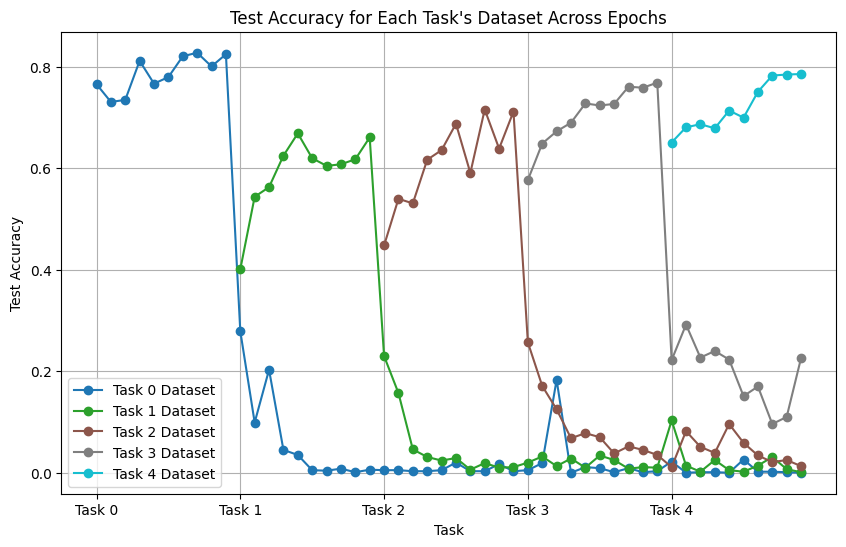


=== Task 1 ===
Epoch 1, Train Loss: 1.8213, Val Loss: 1.4766, Train Accuracy: 0.6488, Val Accuracy: 0.6880
Accuracy on Task 1 at Epoch 1: 0.6880
Epoch 2, Train Loss: 1.1361, Val Loss: 1.2992, Train Accuracy: 0.7254, Val Accuracy: 0.6780
Accuracy on Task 1 at Epoch 2: 0.6780
Epoch 3, Train Loss: 0.9806, Val Loss: 0.9603, Train Accuracy: 0.7460, Val Accuracy: 0.7210
Accuracy on Task 1 at Epoch 3: 0.7210
Epoch 4, Train Loss: 1.0165, Val Loss: 1.2470, Train Accuracy: 0.7417, Val Accuracy: 0.7190
Accuracy on Task 1 at Epoch 4: 0.7190
Epoch 5, Train Loss: 0.8725, Val Loss: 0.8268, Train Accuracy: 0.7598, Val Accuracy: 0.7820
Accuracy on Task 1 at Epoch 5: 0.7820
Epoch 6, Train Loss: 0.8992, Val Loss: 1.0600, Train Accuracy: 0.7590, Val Accuracy: 0.6550
Accuracy on Task 1 at Epoch 6: 0.6550
Epoch 7, Train Loss: 0.8827, Val Loss: 1.5441, Train Accuracy: 0.7518, Val Accuracy: 0.6430
Accuracy on Task 1 at Epoch 7: 0.6430
Epoch 8, Train Loss: 0.8363, Val Loss: 0.6456, Train Accuracy: 0.7649, Val

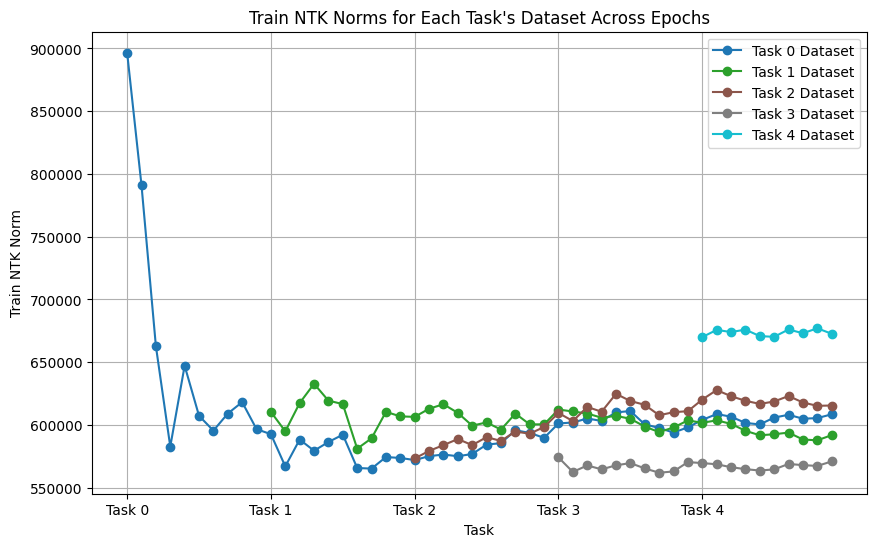

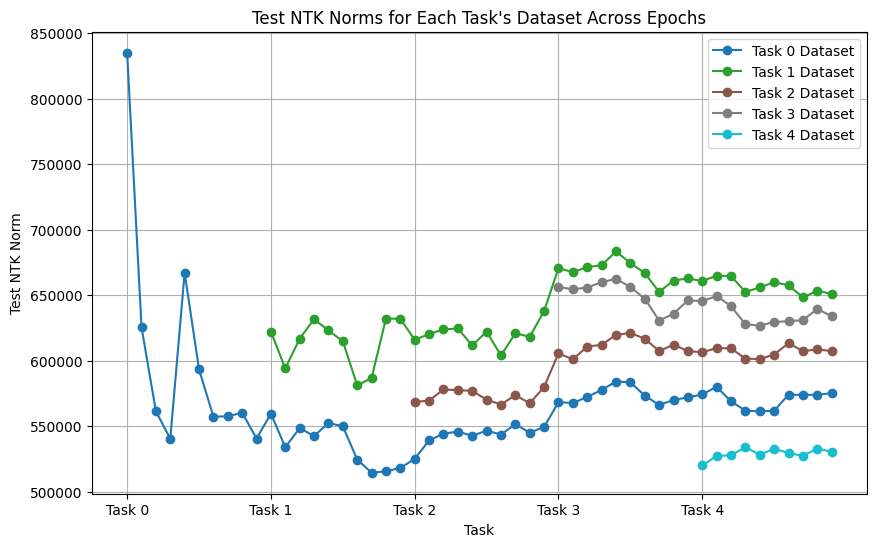

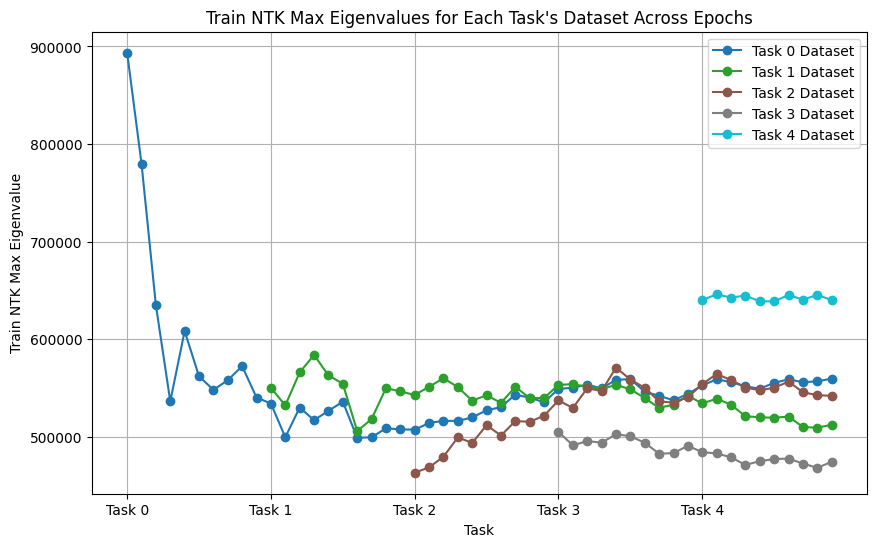

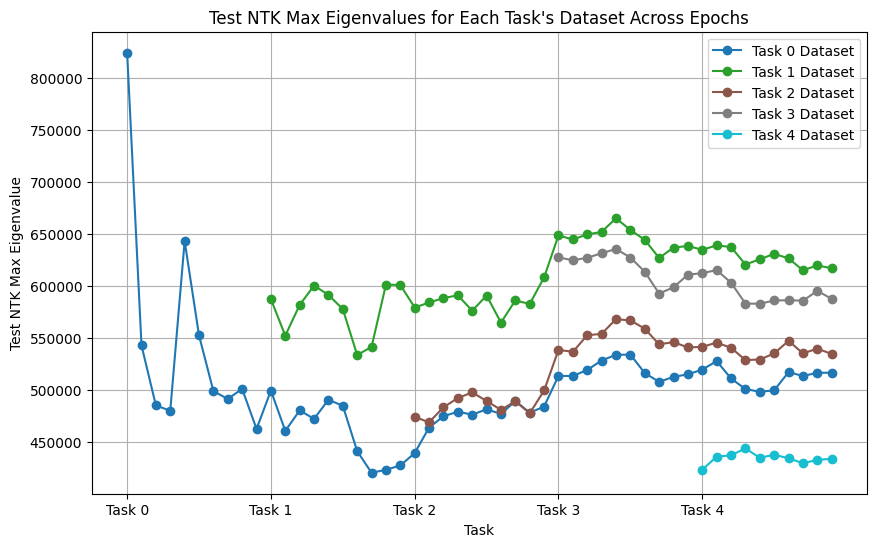

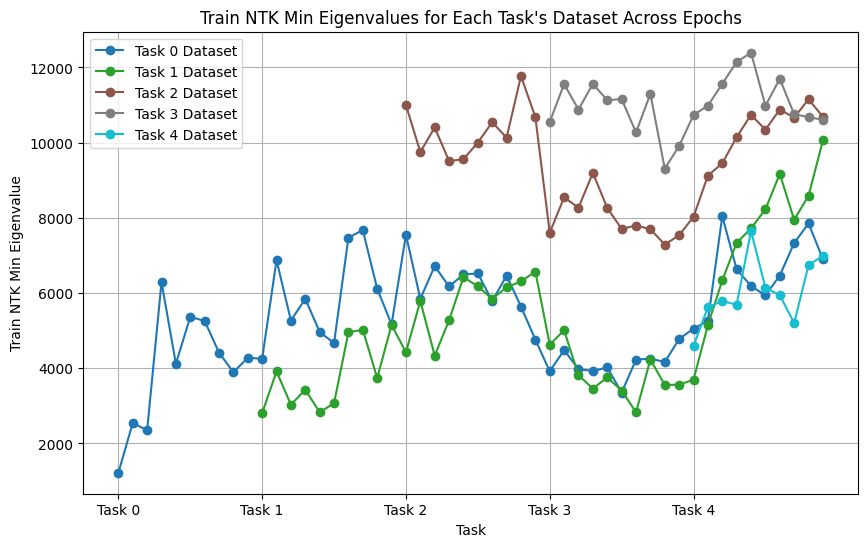

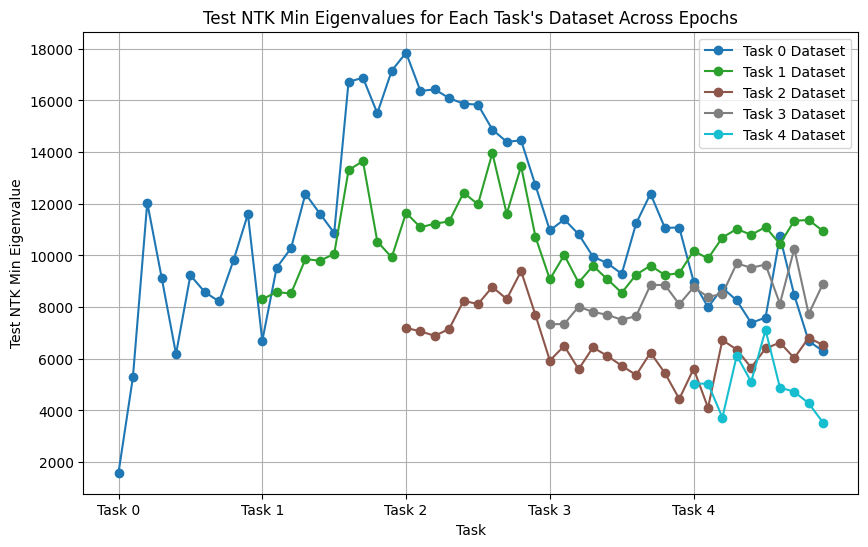

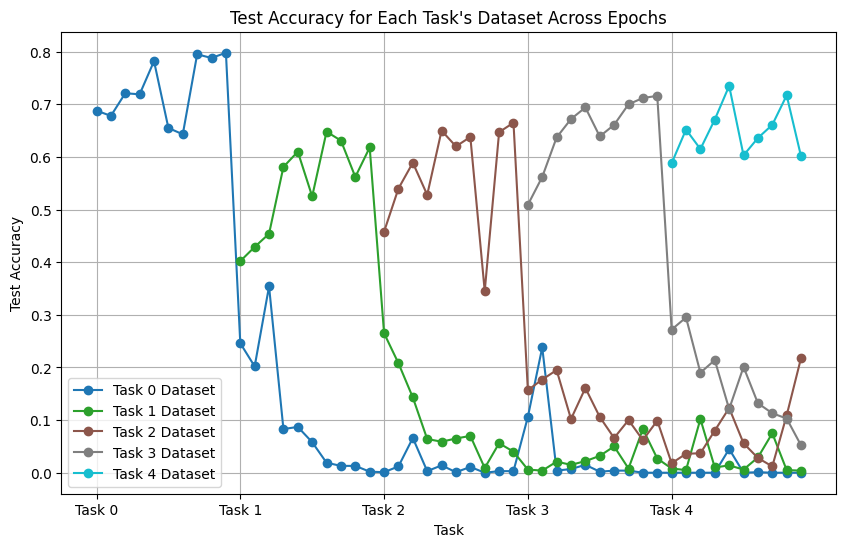

In [6]:
layer_sizes_list = [
    [32 * 32 * 3] + [100] * 3 + [10],
    [32 * 32 * 3] + [500] * 3 + [10],
    [32 * 32 * 3] + [1000] * 3 + [10],
    [32 * 32 * 3] + [5000] * 3 + [10],
    [32 * 32 * 3] + [10000] * 3 + [10]
    
]

metrics = {
    "MLP":{
        "CIFAR10": {
            "2-2-10": {
                "100": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "500": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "1000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "5000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "10000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None}
            }
        }
    }
}

for layer_sizes in layer_sizes_list:
    width = layer_sizes[1]  
    model = NN(layer_sizes).to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs_per_task = 10

    train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate(model, epochs_per_task)

    metrics["MLP"]["CIFAR10"]["2-2-10"][str(width)] = {
        "train_ntk_matrices": train_ntk_matrices,
        "test_ntk_matrices": test_ntk_matrices,
        "task_accuracies": task_accuracies
    }
    
import pickle 
with open("mlp_cifar10_2_2_10epo_cuda.pkl", "wb") as file:
    pickle.dump(metrics, file)


=== Task 1 ===
Epoch 1, Train Loss: 1.1156, Val Loss: 0.7577, Train Accuracy: 0.6967, Val Accuracy: 0.7920
Accuracy on Task 1 at Epoch 1: 0.7920
Epoch 2, Train Loss: 0.6647, Val Loss: 0.5502, Train Accuracy: 0.7964, Val Accuracy: 0.8260
Accuracy on Task 1 at Epoch 2: 0.8260
Epoch 3, Train Loss: 0.4879, Val Loss: 0.4415, Train Accuracy: 0.8237, Val Accuracy: 0.8370
Accuracy on Task 1 at Epoch 3: 0.8370
Epoch 4, Train Loss: 0.4066, Val Loss: 0.3960, Train Accuracy: 0.8372, Val Accuracy: 0.8390
Accuracy on Task 1 at Epoch 4: 0.8390
Epoch 5, Train Loss: 0.3651, Val Loss: 0.3702, Train Accuracy: 0.8512, Val Accuracy: 0.8530
Accuracy on Task 1 at Epoch 5: 0.8530
Epoch 6, Train Loss: 0.3387, Val Loss: 0.3546, Train Accuracy: 0.8584, Val Accuracy: 0.8490
Accuracy on Task 1 at Epoch 6: 0.8490
Epoch 7, Train Loss: 0.3206, Val Loss: 0.3408, Train Accuracy: 0.8672, Val Accuracy: 0.8570
Accuracy on Task 1 at Epoch 7: 0.8570
Epoch 8, Train Loss: 0.3036, Val Loss: 0.3351, Train Accuracy: 0.8743, Val

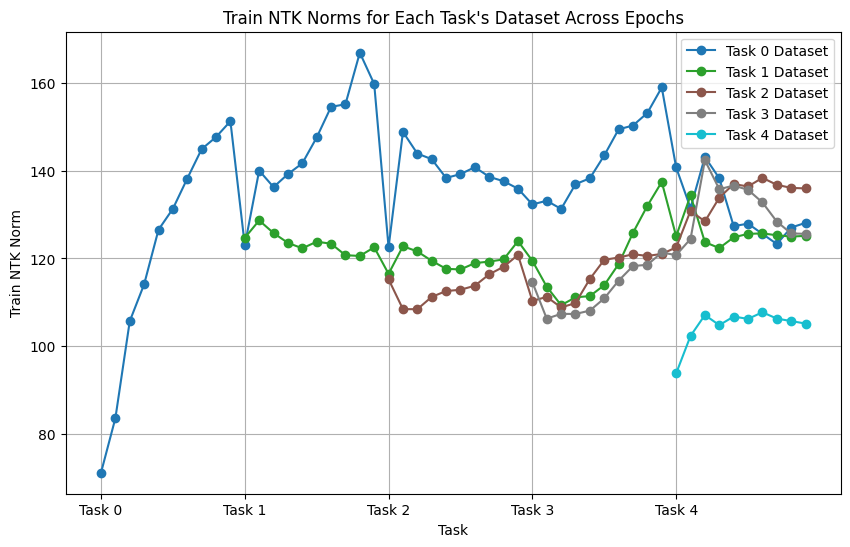

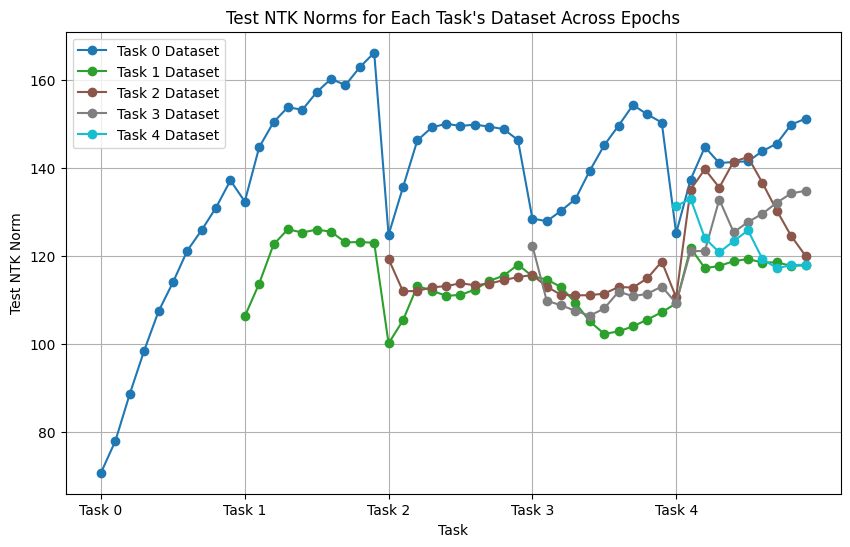

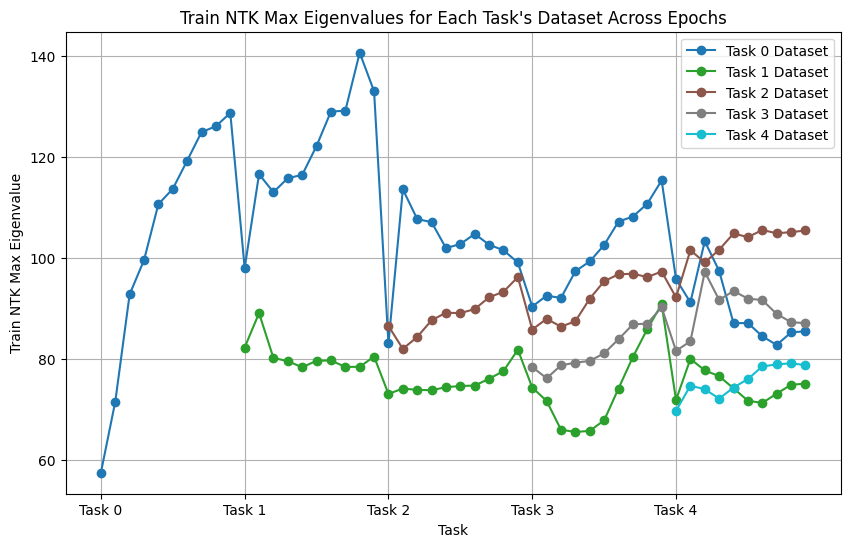

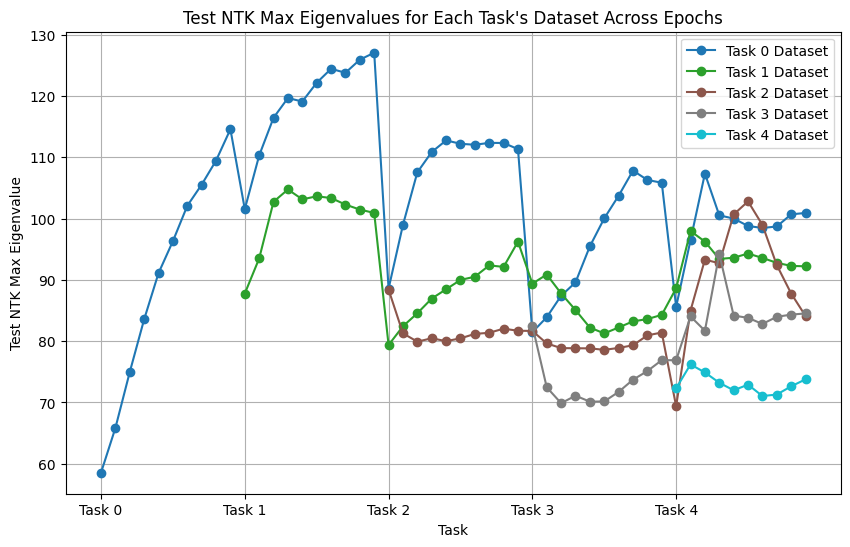

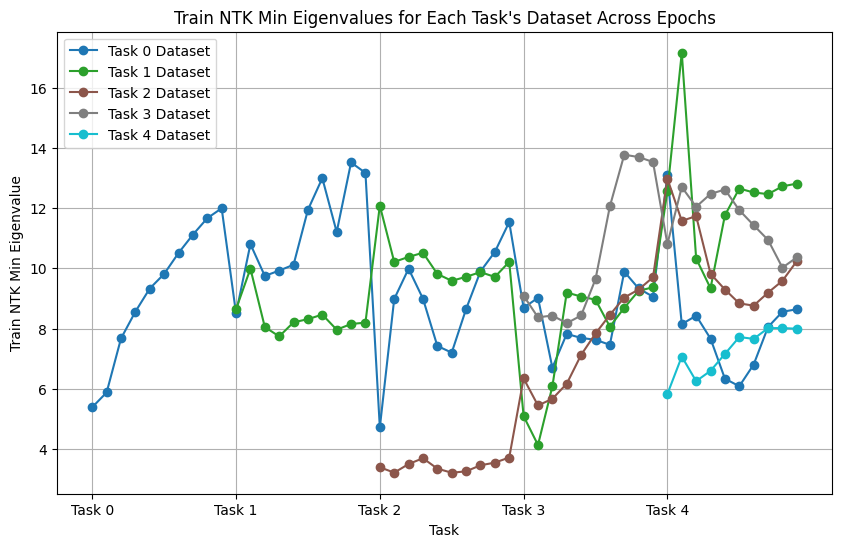

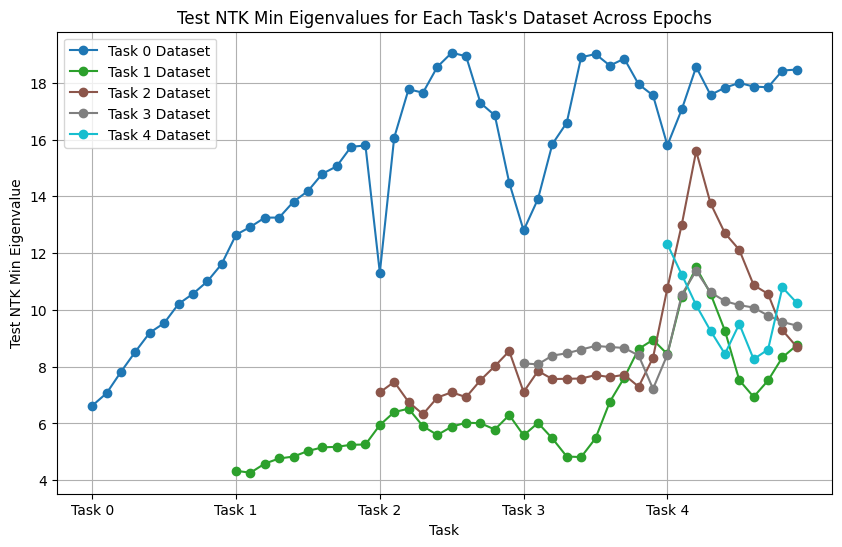

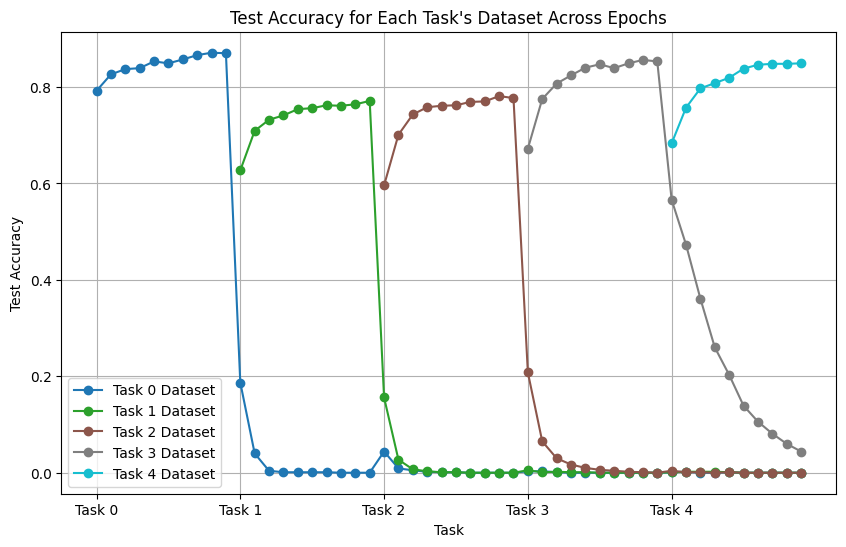


=== Task 1 ===
Epoch 1, Train Loss: 0.9014, Val Loss: 0.6009, Train Accuracy: 0.7404, Val Accuracy: 0.8150
Accuracy on Task 1 at Epoch 1: 0.8150
Epoch 2, Train Loss: 0.4971, Val Loss: 0.4346, Train Accuracy: 0.8252, Val Accuracy: 0.8340
Accuracy on Task 1 at Epoch 2: 0.8340
Epoch 3, Train Loss: 0.3823, Val Loss: 0.3742, Train Accuracy: 0.8477, Val Accuracy: 0.8510
Accuracy on Task 1 at Epoch 3: 0.8510
Epoch 4, Train Loss: 0.3341, Val Loss: 0.3491, Train Accuracy: 0.8606, Val Accuracy: 0.8620
Accuracy on Task 1 at Epoch 4: 0.8620
Epoch 5, Train Loss: 0.3016, Val Loss: 0.3411, Train Accuracy: 0.8769, Val Accuracy: 0.8580
Accuracy on Task 1 at Epoch 5: 0.8580
Epoch 6, Train Loss: 0.2775, Val Loss: 0.3213, Train Accuracy: 0.8908, Val Accuracy: 0.8690
Accuracy on Task 1 at Epoch 6: 0.8690
Epoch 7, Train Loss: 0.2554, Val Loss: 0.3212, Train Accuracy: 0.8991, Val Accuracy: 0.8630
Accuracy on Task 1 at Epoch 7: 0.8630
Epoch 8, Train Loss: 0.2368, Val Loss: 0.3149, Train Accuracy: 0.9089, Val

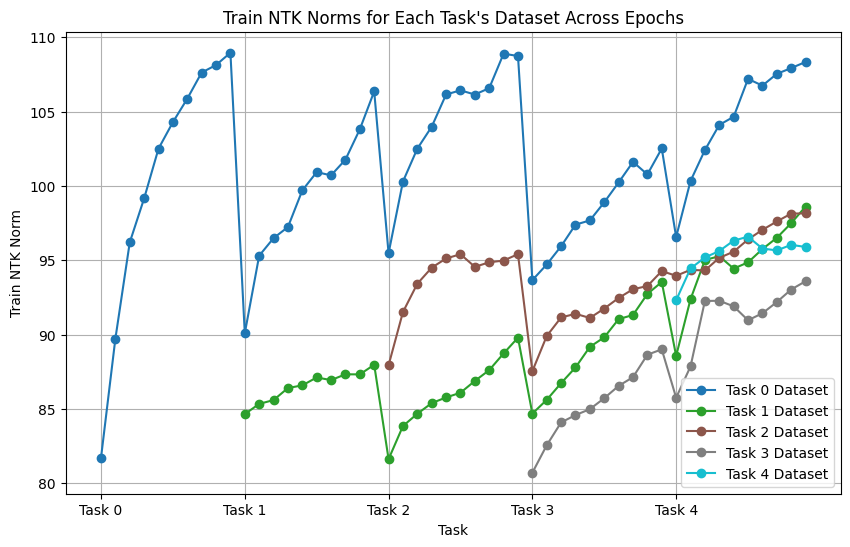

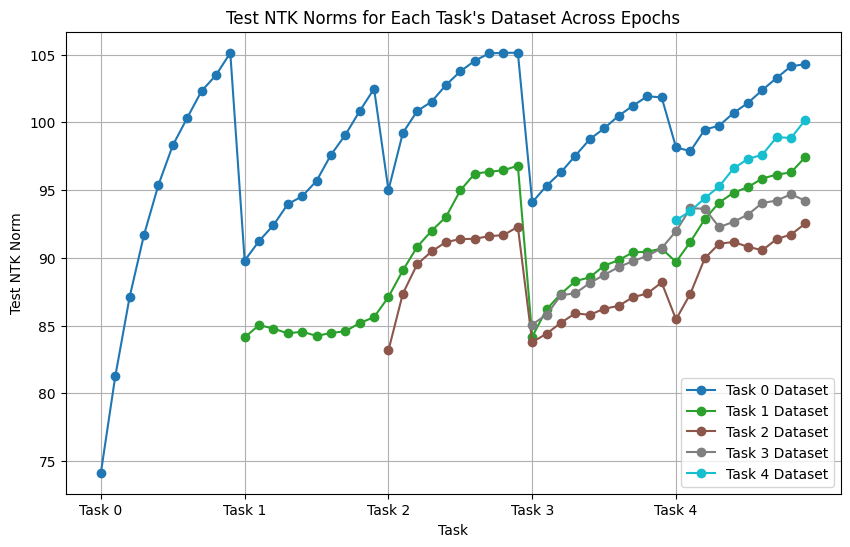

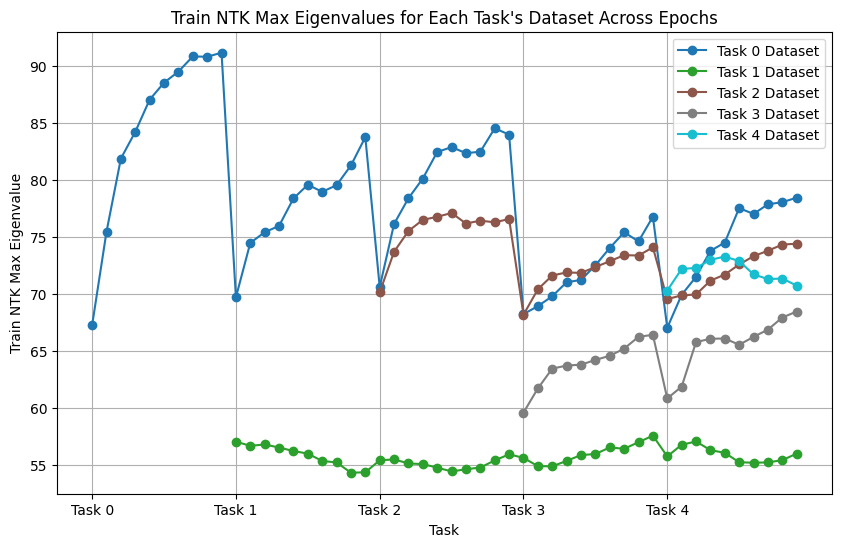

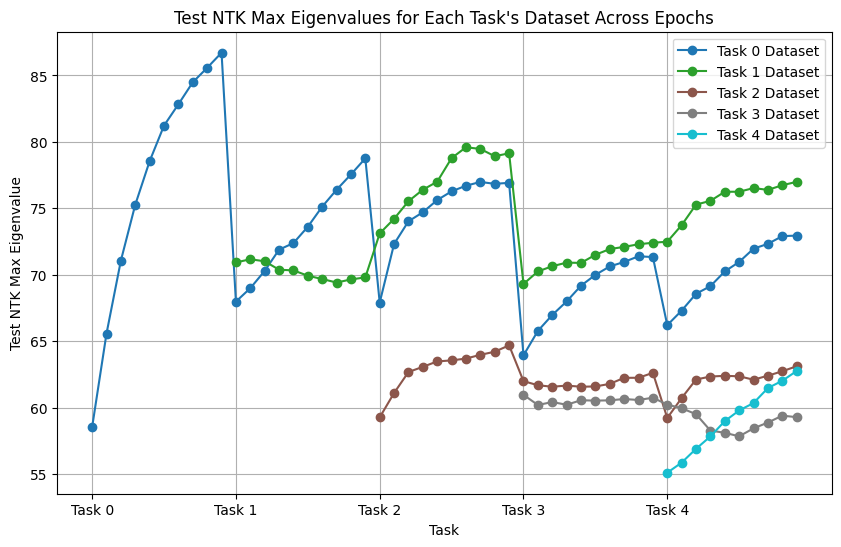

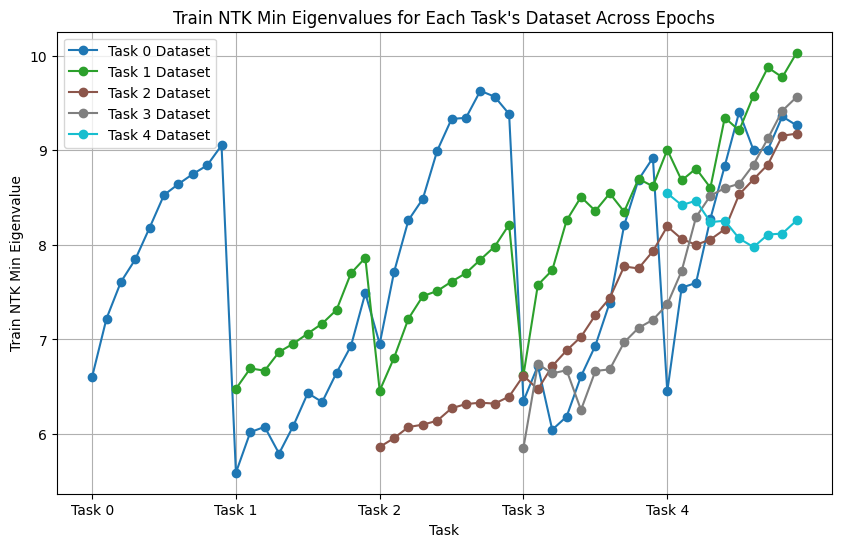

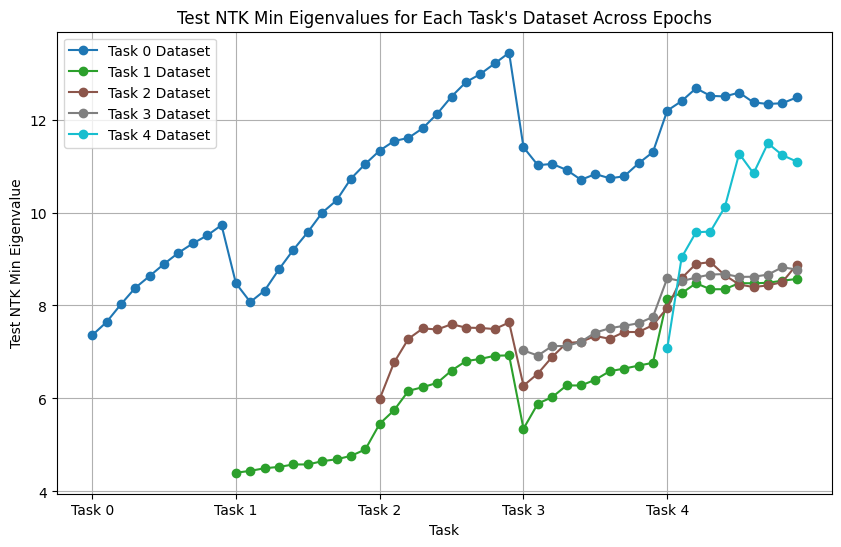

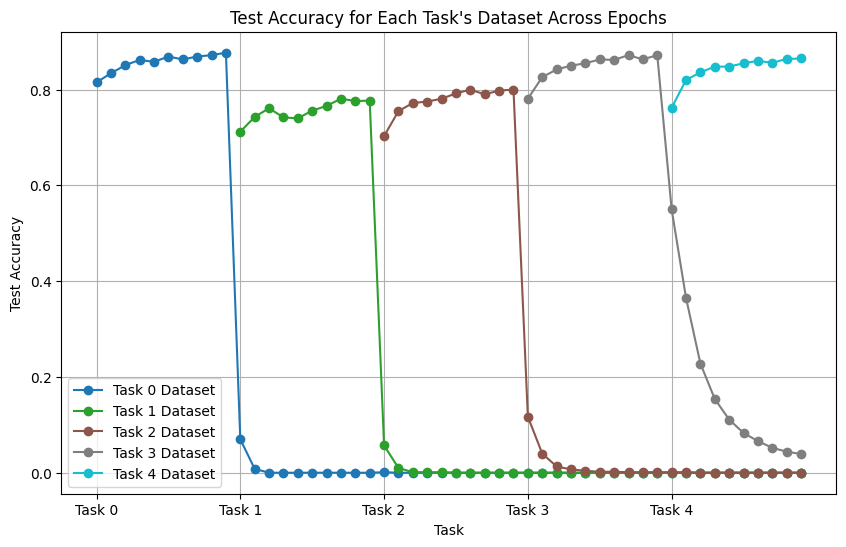


=== Task 1 ===
Epoch 1, Train Loss: 0.8279, Val Loss: 0.5301, Train Accuracy: 0.7544, Val Accuracy: 0.8220
Accuracy on Task 1 at Epoch 1: 0.8220
Epoch 2, Train Loss: 0.4435, Val Loss: 0.4165, Train Accuracy: 0.8388, Val Accuracy: 0.8460
Accuracy on Task 1 at Epoch 2: 0.8460
Epoch 3, Train Loss: 0.3509, Val Loss: 0.3659, Train Accuracy: 0.8576, Val Accuracy: 0.8530
Accuracy on Task 1 at Epoch 3: 0.8530
Epoch 4, Train Loss: 0.3041, Val Loss: 0.3420, Train Accuracy: 0.8778, Val Accuracy: 0.8610
Accuracy on Task 1 at Epoch 4: 0.8610
Epoch 5, Train Loss: 0.2710, Val Loss: 0.3397, Train Accuracy: 0.8922, Val Accuracy: 0.8580
Accuracy on Task 1 at Epoch 5: 0.8580
Epoch 6, Train Loss: 0.2456, Val Loss: 0.3269, Train Accuracy: 0.9054, Val Accuracy: 0.8700
Accuracy on Task 1 at Epoch 6: 0.8700
Epoch 7, Train Loss: 0.2247, Val Loss: 0.3258, Train Accuracy: 0.9159, Val Accuracy: 0.8700
Accuracy on Task 1 at Epoch 7: 0.8700
Epoch 8, Train Loss: 0.2029, Val Loss: 0.3114, Train Accuracy: 0.9294, Val

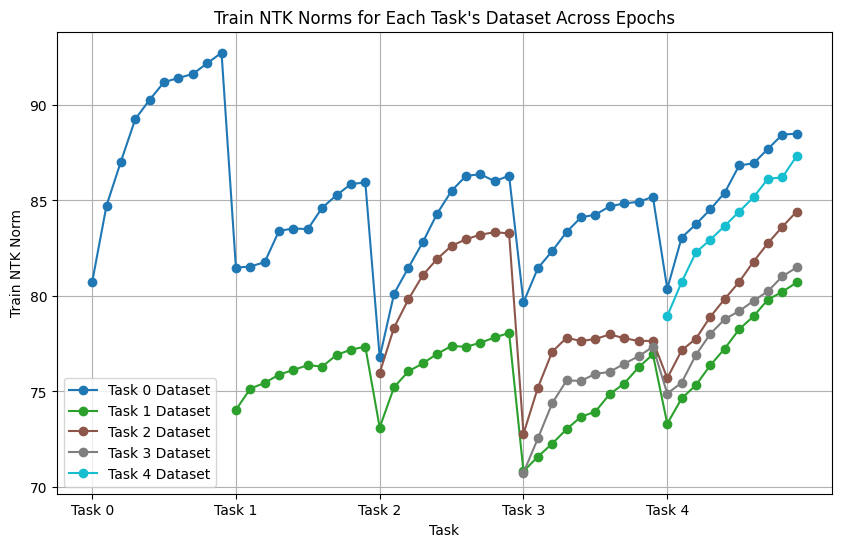

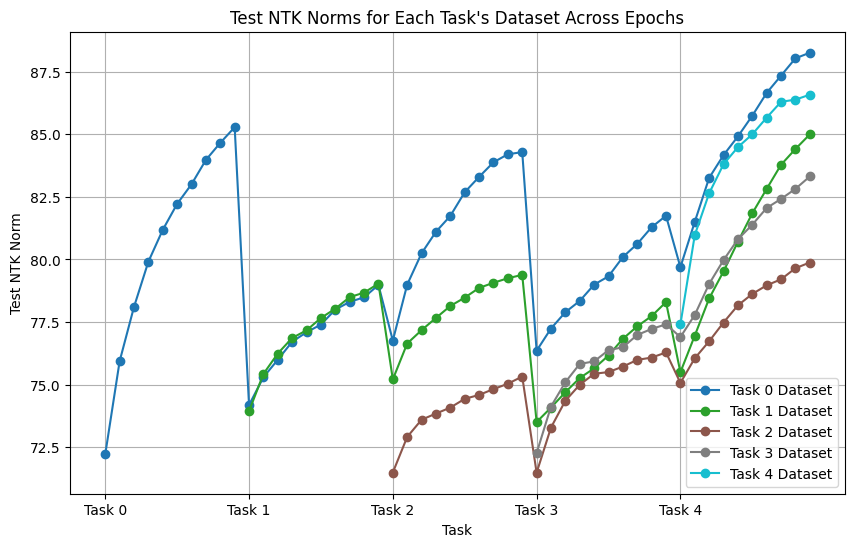

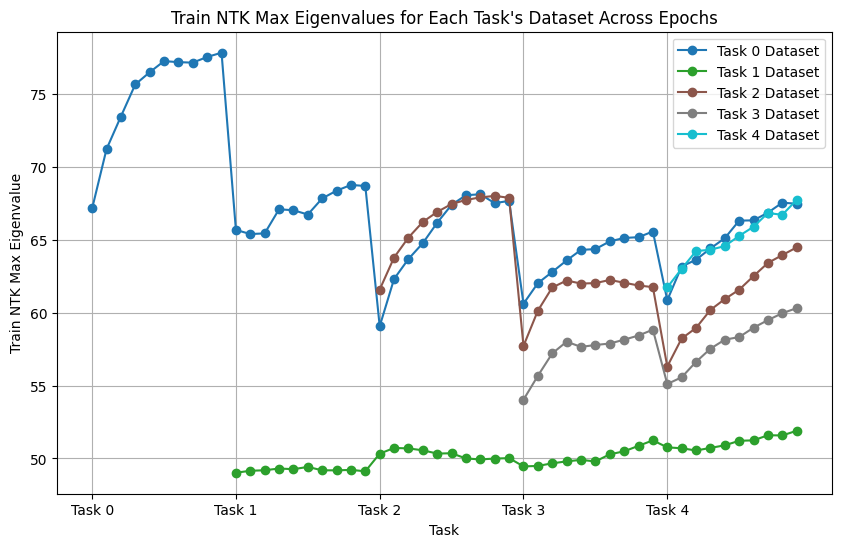

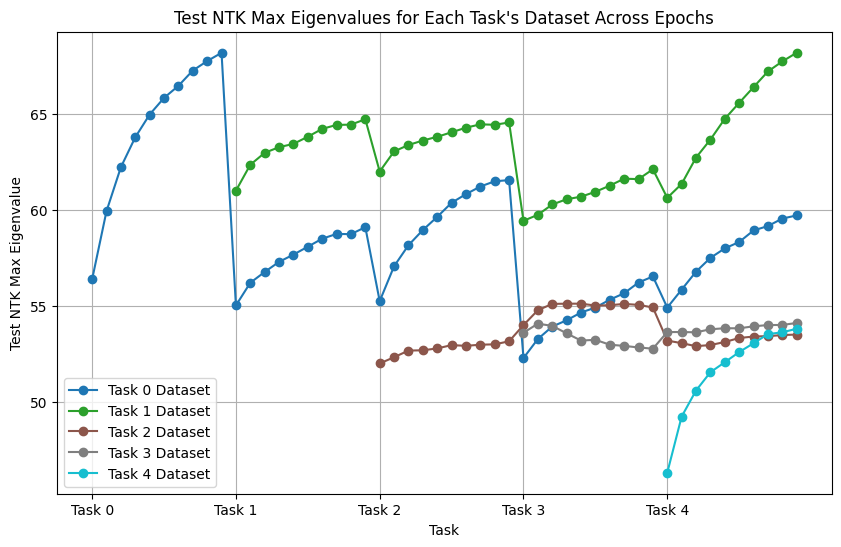

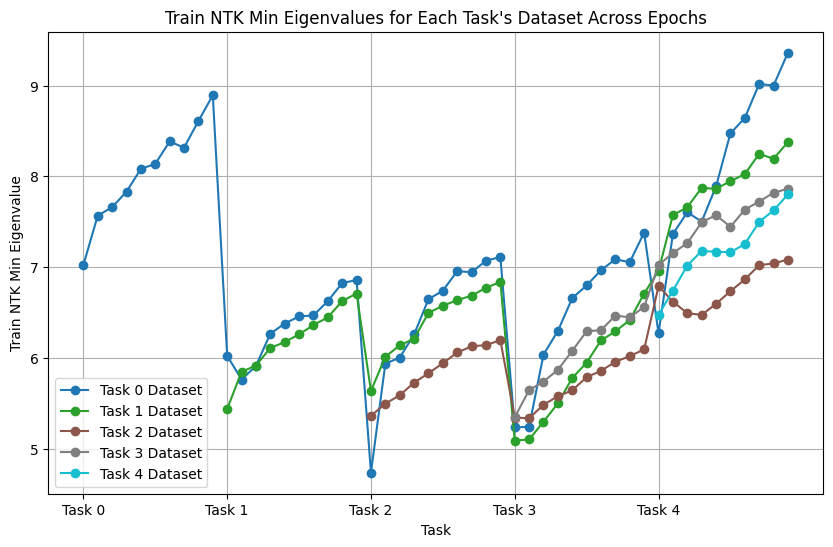

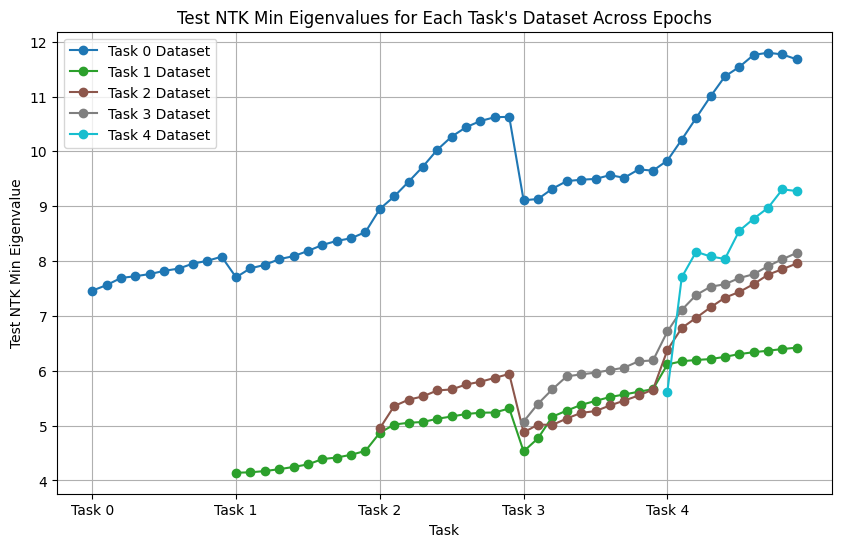

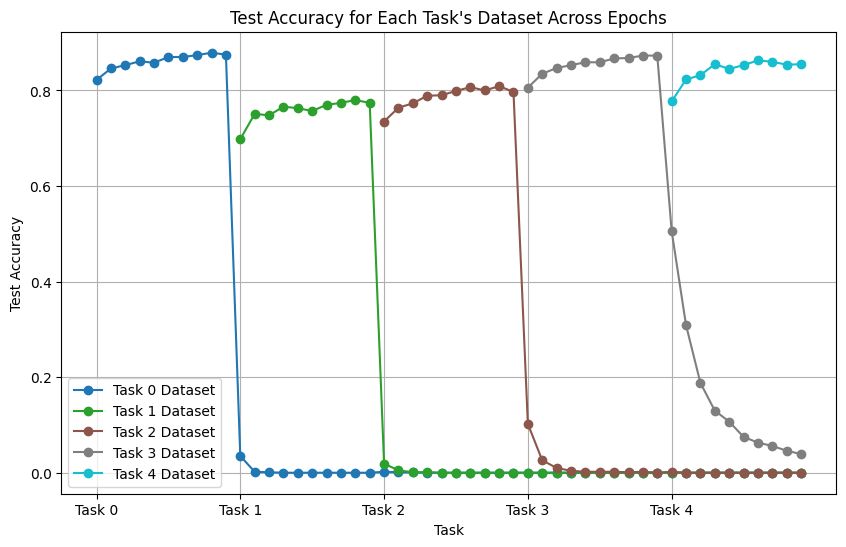


=== Task 1 ===
Epoch 1, Train Loss: 0.6872, Val Loss: 0.4633, Train Accuracy: 0.7773, Val Accuracy: 0.8220
Accuracy on Task 1 at Epoch 1: 0.8220
Epoch 2, Train Loss: 0.3649, Val Loss: 0.3594, Train Accuracy: 0.8493, Val Accuracy: 0.8540
Accuracy on Task 1 at Epoch 2: 0.8540
Epoch 3, Train Loss: 0.2856, Val Loss: 0.3440, Train Accuracy: 0.8847, Val Accuracy: 0.8470
Accuracy on Task 1 at Epoch 3: 0.8470
Epoch 4, Train Loss: 0.2348, Val Loss: 0.3414, Train Accuracy: 0.9121, Val Accuracy: 0.8560
Accuracy on Task 1 at Epoch 4: 0.8560
Epoch 5, Train Loss: 0.1999, Val Loss: 0.3350, Train Accuracy: 0.9277, Val Accuracy: 0.8520
Accuracy on Task 1 at Epoch 5: 0.8520
Epoch 6, Train Loss: 0.1730, Val Loss: 0.3238, Train Accuracy: 0.9422, Val Accuracy: 0.8580
Accuracy on Task 1 at Epoch 6: 0.8580
Epoch 7, Train Loss: 0.1526, Val Loss: 0.3292, Train Accuracy: 0.9527, Val Accuracy: 0.8650
Accuracy on Task 1 at Epoch 7: 0.8650
Epoch 8, Train Loss: 0.1293, Val Loss: 0.3206, Train Accuracy: 0.9678, Val

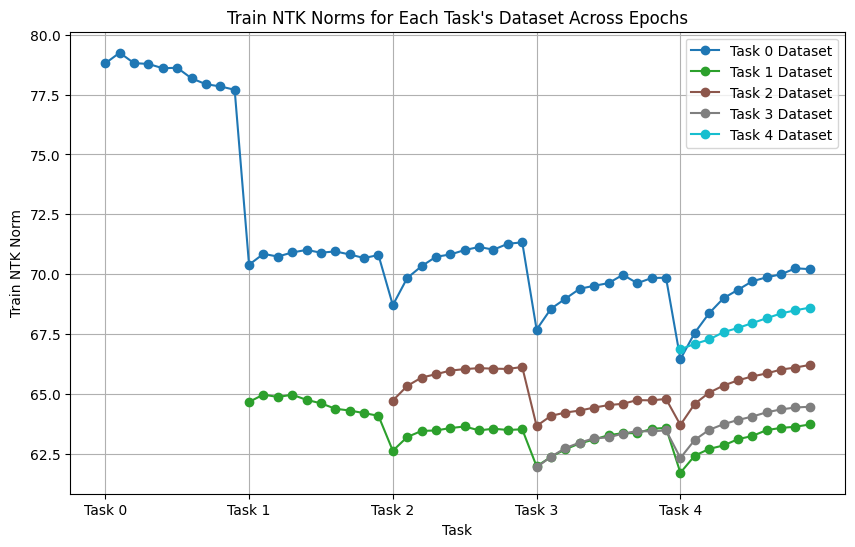

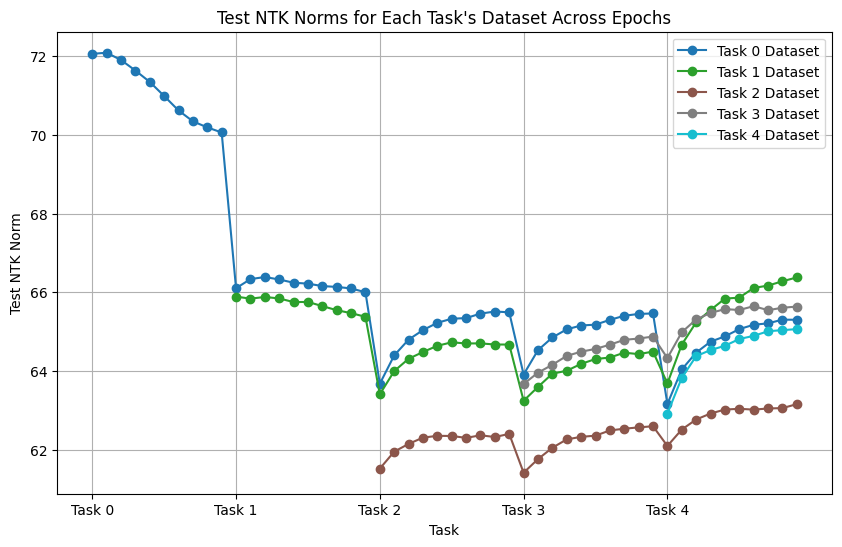

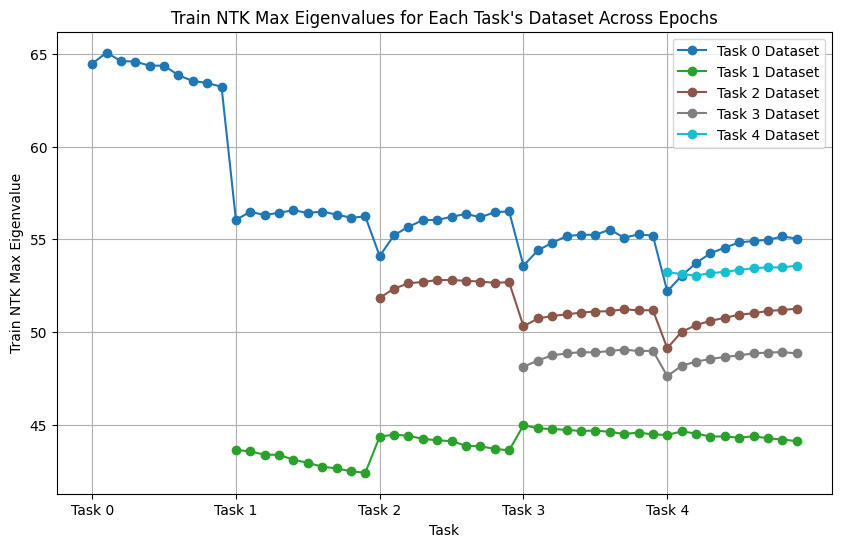

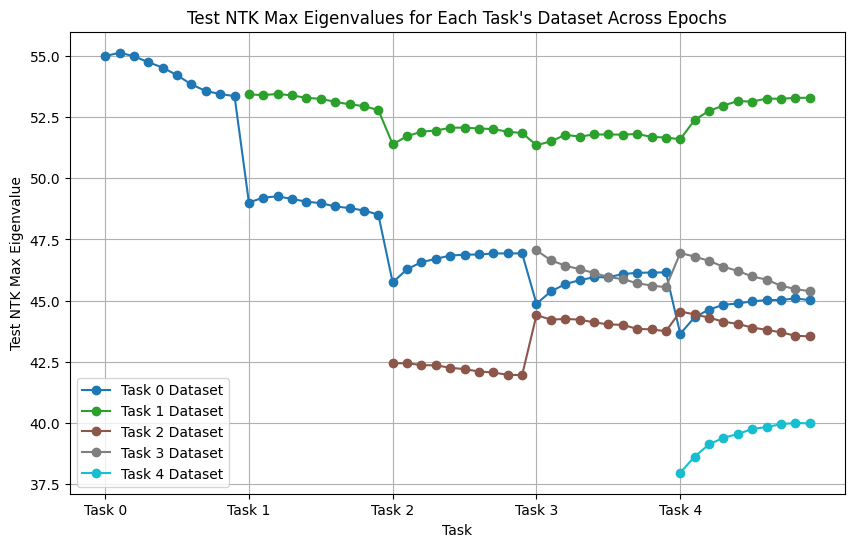

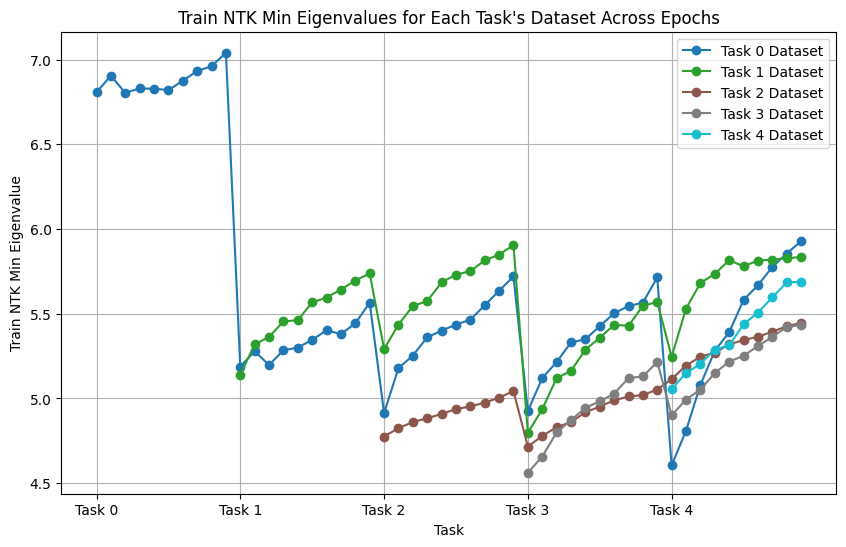

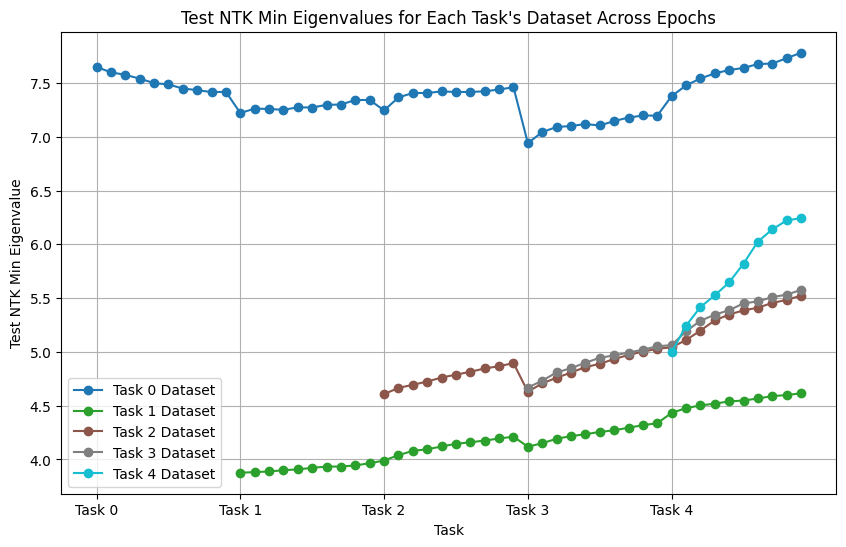

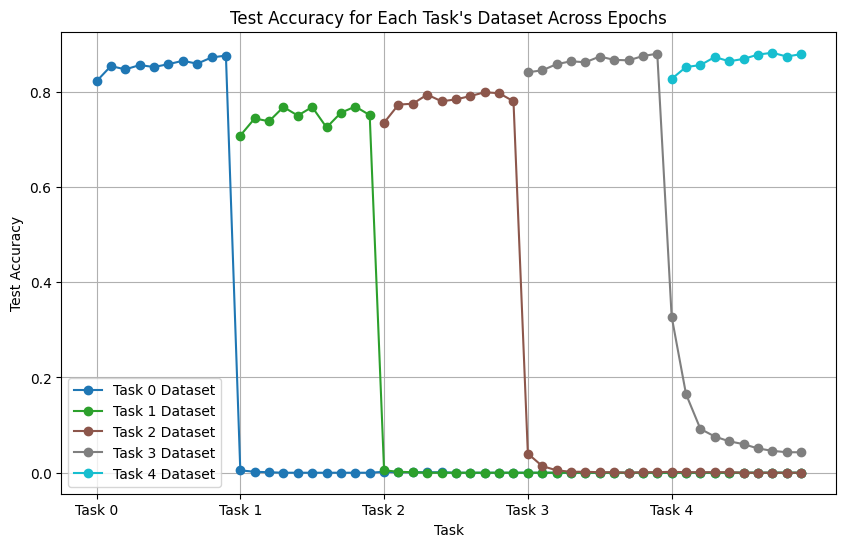


=== Task 1 ===
Epoch 1, Train Loss: 0.6231, Val Loss: 0.3905, Train Accuracy: 0.7939, Val Accuracy: 0.8430
Accuracy on Task 1 at Epoch 1: 0.8430
Epoch 2, Train Loss: 0.3265, Val Loss: 0.3730, Train Accuracy: 0.8657, Val Accuracy: 0.8390
Accuracy on Task 1 at Epoch 2: 0.8390
Epoch 3, Train Loss: 0.2512, Val Loss: 0.3426, Train Accuracy: 0.9010, Val Accuracy: 0.8660
Accuracy on Task 1 at Epoch 3: 0.8660
Epoch 4, Train Loss: 0.1984, Val Loss: 0.3177, Train Accuracy: 0.9280, Val Accuracy: 0.8670
Accuracy on Task 1 at Epoch 4: 0.8670
Epoch 5, Train Loss: 0.1616, Val Loss: 0.3403, Train Accuracy: 0.9482, Val Accuracy: 0.8580
Accuracy on Task 1 at Epoch 5: 0.8580
Epoch 6, Train Loss: 0.1354, Val Loss: 0.3343, Train Accuracy: 0.9629, Val Accuracy: 0.8610
Accuracy on Task 1 at Epoch 6: 0.8610
Epoch 7, Train Loss: 0.1146, Val Loss: 0.3219, Train Accuracy: 0.9722, Val Accuracy: 0.8700
Accuracy on Task 1 at Epoch 7: 0.8700
Epoch 8, Train Loss: 0.0964, Val Loss: 0.3207, Train Accuracy: 0.9807, Val

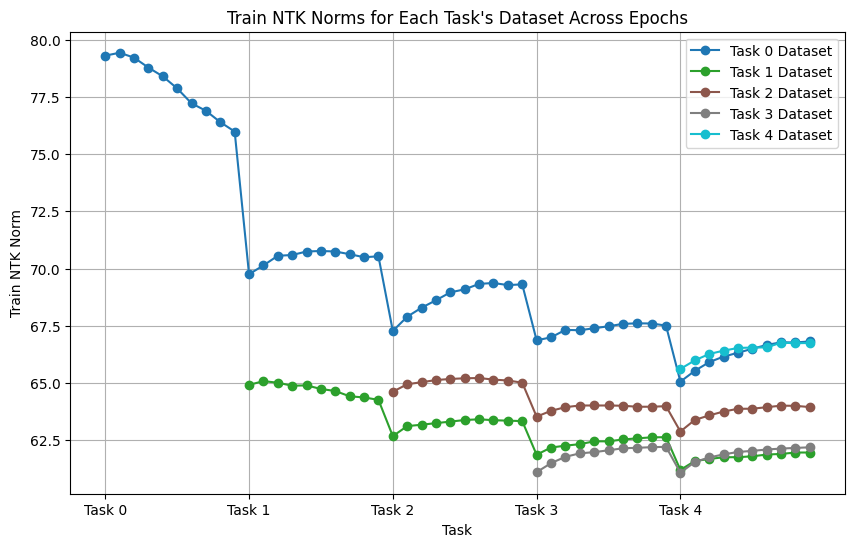

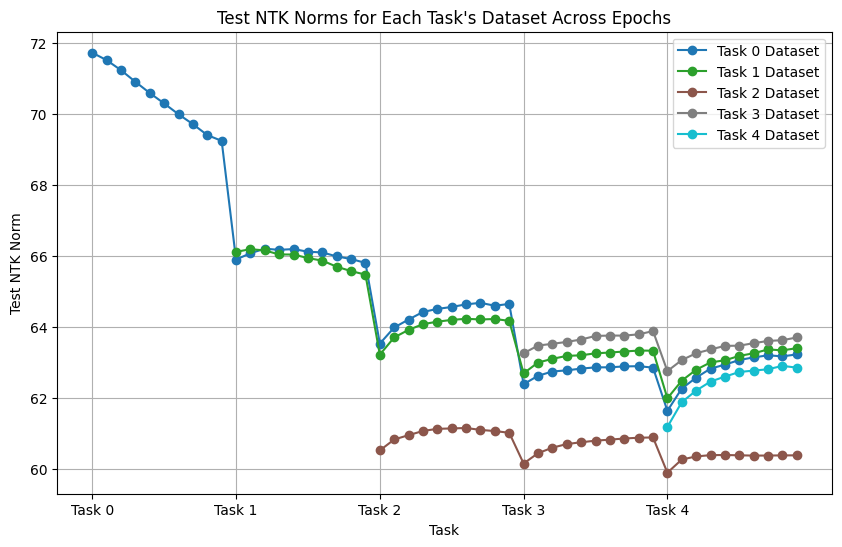

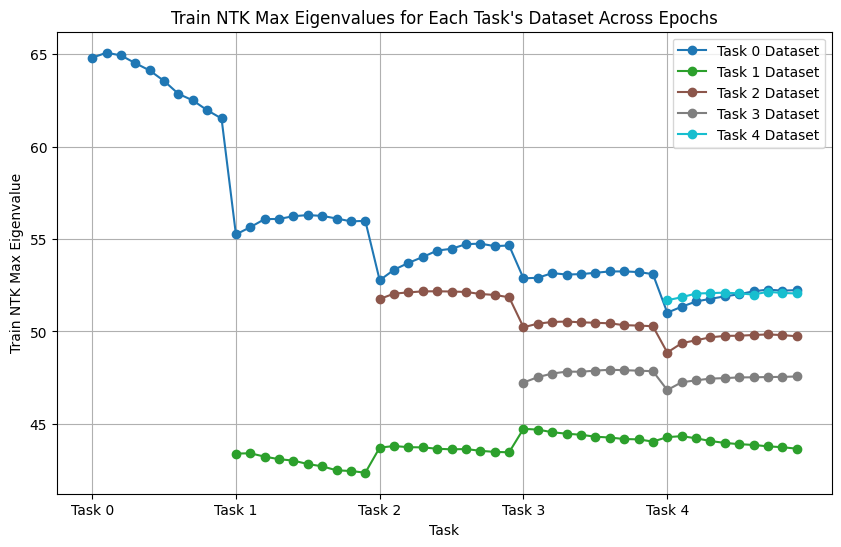

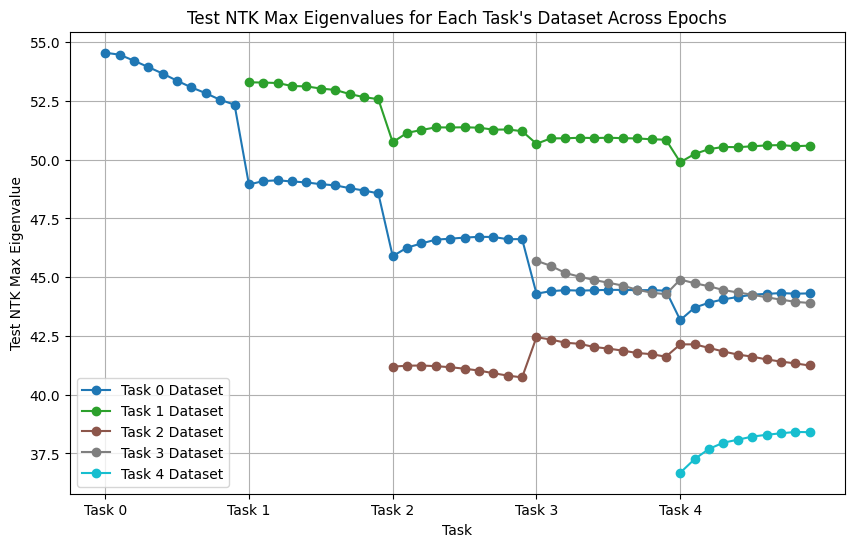

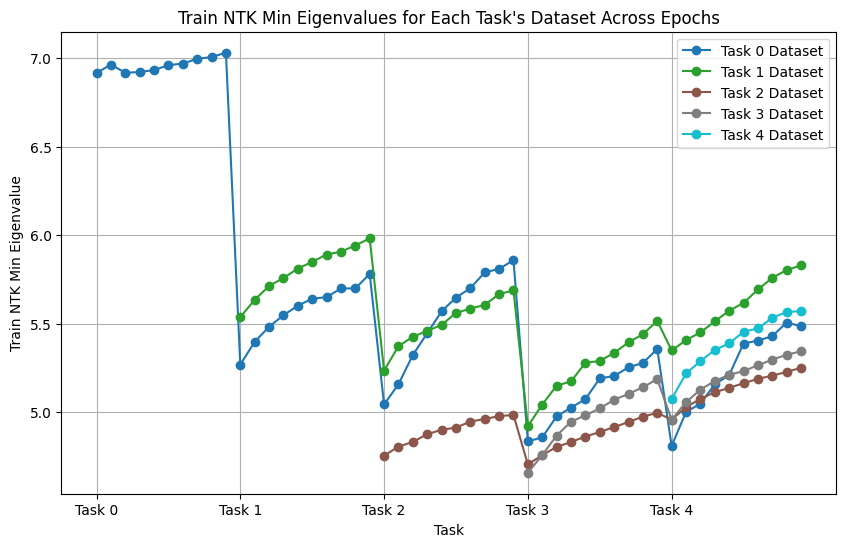

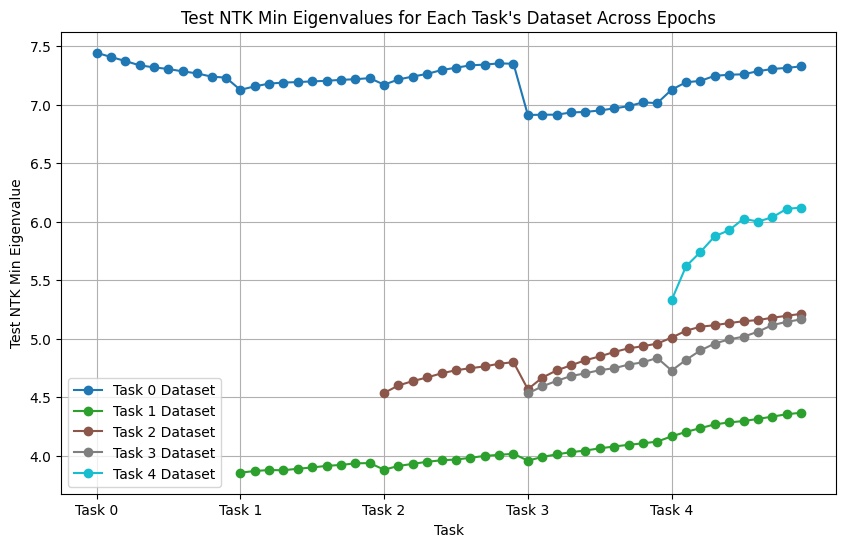

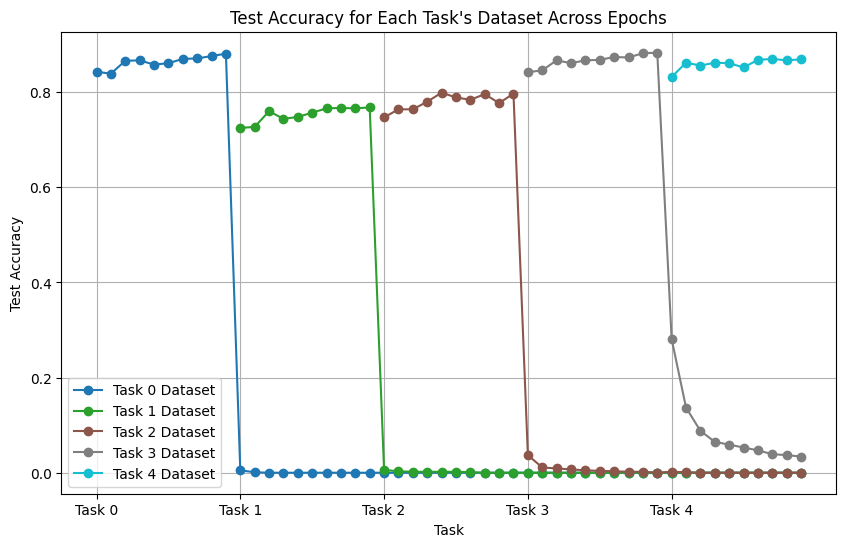

In [4]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, indim, statedim, outdim=1, nonlin=torch.erf, varw=1, varu=1, varb=0, varv=1,
                 avgpool=False, debug=False):
        super().__init__()
        self.varu = varu
        self.varw = varw
        self.varb = varb
        self.varv = varv
        self.nonlin = nonlin
        self.avgpool = avgpool
        self.debug = debug
        self.W = nn.Parameter(torch.randn(statedim, statedim))
        self.U = nn.Parameter(torch.randn(indim, statedim))
        self.b = nn.Parameter(torch.randn(statedim))
        self.v = nn.Parameter(torch.randn(statedim, outdim))
        self.randomize()

    def forward(self, inp, initstate=0):
        # Flatten the input to [batch_size, features]
        inp = inp.view(inp.size(0), -1)  # Flatten to [batch_size, indim]
        indim = self.U.shape[0]
        statedim = self.U.shape[1]
        embed = torch.einsum('bi,ij->bj', inp, self.U) / np.sqrt(indim) + self.b
        seqlen = 1  # Since we flattened the input, seqlen is 1
        state = initstate
        self._states = []
        self.hs = []
        for i in range(seqlen):
            h = embed + state  # embed is [batch_size, statedim], state is [batch_size, statedim]
            state = self.nonlin(h)
            self._states.append(state)
            if self.debug:
                state.retain_grad()
                self.hs.append(h)
            if i < seqlen - 1:
                state = state @ self.W / np.sqrt(statedim)
            else:
                if self.avgpool:
                    meanstate = sum(self._states) / len(self._states)
                    return meanstate @ self.v / np.sqrt(statedim)
                else:
                    return state @ self.v / np.sqrt(statedim)

    def randomize(self, varu=None, varw=None, varb=None, varv=None):
        varu = varu or self.varu
        varw = varw or self.varw
        varb = varb or self.varb
        varv = varv or self.varv
        with torch.no_grad():
            self.W.normal_(std=np.sqrt(varw))
            self.U.normal_(std=np.sqrt(varu))
            self.v.normal_(std=np.sqrt(varv))
            if varb > 0:
                self.b.normal_(std=np.sqrt(varb))
            else:
                self.b.zero_()

                
metrics = {
    "RNN":{
        "CIFAR10": {
            "2-2-10": {
                "100": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "500": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "1000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "5000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "10000": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None}
            }
        }
    }
}

indim = 3 * 32 * 32  # CIFAR-10 image size (3 channels, 32x32 pixels)
statedim_list = [100,500,1000,5000,10000]
outdim = 10

for statedim in statedim_list:
    width = statedim 
    model = SimpleRNNClassifier(indim, statedim, outdim).to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs_per_task = 10

    train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate(model, epochs_per_task)

    metrics["RNN"]["CIFAR10"]["2-2-10"][str(width)] = {
        "train_ntk_matrices": train_ntk_matrices,
        "test_ntk_matrices": test_ntk_matrices,
        "task_accuracies": task_accuracies
    }


In [5]:
import pickle 
with open("rnn_cifar10_2_2_10epo_cuda.pkl", "wb") as file:
    pickle.dump(metrics, file)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR100, CIFAR10
from continuum.tasks import split_train_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR10("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=2,  # Add 2 new classes per task
    initial_increment=2  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_channel):
        super(CNN, self).__init__()
        self.conv_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_dim, num_channel, kernel_size=5),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.pool1 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.conv_layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.backbone = nn.Sequential(
            self.conv_layer1,
            self.conv_layer2,
            self.pool1,
            self.conv_layer3,
            self.conv_layer4,
            nn.Flatten(start_dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(num_channel*9*9, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0).to(device))  # Add batch dimension and move to GPU
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize, device=device)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk.cpu().numpy()  # Move NTK matrix back to CPU for plotting

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)  # Move data to GPU
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Lists to store fixed samples and validation tasksets
fixed_train_samples = []
fixed_val_samples = []
val_tasksets = []
train_tasksets = []

# Function to extract fixed samples and validation tasksets
def extract_fixed_samples_and_tasksets(scenario):
    for task_id, train_taskset in enumerate(scenario):
        # Split the taskset into training and validation sets
        train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
        
        # Store fixed samples for NTK calculation
        fixed_train_samples.append([train_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        fixed_val_samples.append([val_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        
        # Store validation taskset
        val_tasksets.append(val_taskset)
        train_tasksets.append(train_taskset)

# Function to train, evaluate, and plot NTK metrics
def train_and_evaluate(model, epochs_per_task):
    num_tasks = len(val_tasksets)
    total_epochs = num_tasks * epochs_per_task

    # Initialize lists to store results
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    task_accuracies = [[] for _ in range(num_tasks)]  # Accuracy on all tasks after each epoch
    train_ntk_matrices = [[] for _ in range(num_tasks)]
    test_ntk_matrices = [[] for _ in range(num_tasks)]

    # Train and evaluate on each task
    for task_id in range(num_tasks):
        print(f"\n=== Task {task_id + 1} ===")
        
        train_loader = DataLoader(train_tasksets[task_id], batch_size=32, shuffle=True)
        val_loader = DataLoader(val_tasksets[task_id], batch_size=32, shuffle=False)
        
        # Train the model on the current task
        model.train()
        for epoch in range(epochs_per_task):
            global_epoch = task_id * epochs_per_task + epoch  # Global epoch index
            running_loss = 0.0
            running_accuracy = 0.0
            correct = 0
            total = 0
            for x, y, t in train_loader:
                x, y = x.to(device), y.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct += (pred == y).sum().item()
                total += y.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Evaluate on the validation set
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {global_epoch + 1}, "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Calculate NTK for fixed samples at the end of each epoch
            model.eval()
            for t in range(task_id + 1):
                train_ntk = simrnn_ntk(fixed_train_samples[t], model)
                test_ntk = simrnn_ntk(fixed_val_samples[t], model)
                train_ntk_matrices[t].append(train_ntk)
                test_ntk_matrices[t].append(test_ntk)

            # Evaluate the model on all tasks seen so far using fixed validation sets
            for t in range(task_id + 1):
                val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
                _, accuracy = evaluate(model, val_loader_t, criterion)
                task_accuracies[t].append(accuracy)
                print(f"Accuracy on Task {t + 1} at Epoch {global_epoch + 1}: {accuracy:.4f}")

    def calculate_ntk_metrics(ntk_matrices):
        norms = []
        max_eigenvalues = []
        min_eigenvalues = []
        for task_ntk_matrices in ntk_matrices:
            task_norms = []
            task_max_eigenvalues = []
            task_min_eigenvalues = []
            for ntk_matrix in task_ntk_matrices:
                task_norms.append(np.linalg.norm(ntk_matrix, ord='fro'))  # Use numpy.linalg.norm
                eigenvalues = np.linalg.eigvalsh(ntk_matrix)  # Use numpy.linalg.eigvalsh
                task_max_eigenvalues.append(eigenvalues[-1])
                task_min_eigenvalues.append(eigenvalues[0])
            norms.append(task_norms)
            max_eigenvalues.append(task_max_eigenvalues)
            min_eigenvalues.append(task_min_eigenvalues)
        return norms, max_eigenvalues, min_eigenvalues

    # Calculate NTK metrics for train and test NTK matrices
    train_ntk_norms, train_ntk_max_eigenvalues, train_ntk_min_eigenvalues = calculate_ntk_metrics(train_ntk_matrices)
    test_ntk_norms, test_ntk_max_eigenvalues, test_ntk_min_eigenvalues = calculate_ntk_metrics(test_ntk_matrices)

        
    def plot_ntk_metrics(ntk_metrics, title, ylabel):
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_metrics)))  # Assign a color to each task

        for t in range(len(ntk_metrics)):
            # Extract NTK metrics for Task t's dataset
            ntk_metrics_task = ntk_metrics[t]

            # The x-axis starts from the epoch when the task was introduced
            x_values = range(t * epochs_per_task, total_epochs)
            y_values = ntk_metrics_task

            # Plot the curve for Task t's dataset
            plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

        # Customize x-axis ticks and labels
        xticks = np.arange(0, total_epochs, epochs_per_task)  # Set ticks at the start of each task
        xticklabels = [f"Task {i}" for i in range(len(xticks))]  # Label ticks as Task 0, Task 1, etc.
        plt.xticks(xticks, xticklabels)  # Apply custom ticks and labels

        plt.xlabel('Task')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot NTK norms
    plot_ntk_metrics(train_ntk_norms, title='Train NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Norm')
    plot_ntk_metrics(test_ntk_norms, title='Test NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Norm')

    # Plot NTK max eigenvalues
    plot_ntk_metrics(train_ntk_max_eigenvalues, title='Train NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Max Eigenvalue')
    plot_ntk_metrics(test_ntk_max_eigenvalues, title='Test NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Max Eigenvalue')

    # Plot NTK min eigenvalues
    plot_ntk_metrics(train_ntk_min_eigenvalues, title='Train NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Min Eigenvalue')
    plot_ntk_metrics(test_ntk_min_eigenvalues, title='Test NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Min Eigenvalue')

    # Plot task accuracies
    plot_ntk_metrics(task_accuracies, title='Test Accuracy for Each Task\'s Dataset Across Epochs', ylabel='Test Accuracy')

    return train_ntk_matrices, test_ntk_matrices, task_accuracies

# Example usage:
# First, extract fixed samples and tasksets
extract_fixed_samples_and_tasksets(scenario)


Using device: cuda
Files already downloaded and verified
Number of classes: 10.
Number of tasks: 5.



=== Task 1 ===
Epoch 1, Train Loss: 0.3344, Val Loss: 0.2280, Train Accuracy: 0.8608, Val Accuracy: 0.9140
Accuracy on Task 1 at Epoch 1: 0.9140
Epoch 2, Train Loss: 0.2077, Val Loss: 0.2262, Train Accuracy: 0.9139, Val Accuracy: 0.9170
Accuracy on Task 1 at Epoch 2: 0.9170
Epoch 3, Train Loss: 0.1544, Val Loss: 0.2223, Train Accuracy: 0.9407, Val Accuracy: 0.9130
Accuracy on Task 1 at Epoch 3: 0.9130
Epoch 4, Train Loss: 0.1191, Val Loss: 0.1409, Train Accuracy: 0.9557, Val Accuracy: 0.9510
Accuracy on Task 1 at Epoch 4: 0.9510
Epoch 5, Train Loss: 0.0970, Val Loss: 0.1275, Train Accuracy: 0.9634, Val Accuracy: 0.9560
Accuracy on Task 1 at Epoch 5: 0.9560
Epoch 6, Train Loss: 0.0760, Val Loss: 0.2050, Train Accuracy: 0.9717, Val Accuracy: 0.9050
Accuracy on Task 1 at Epoch 6: 0.9050
Epoch 7, Train Loss: 0.0706, Val Loss: 0.1630, Train Accuracy: 0.9728, Val Accuracy: 0.9420
Accuracy on Task 1 at Epoch 7: 0.9420
Epoch 8, Train Loss: 0.0661, Val Loss: 0.1659, Train Accuracy: 0.9762, Val

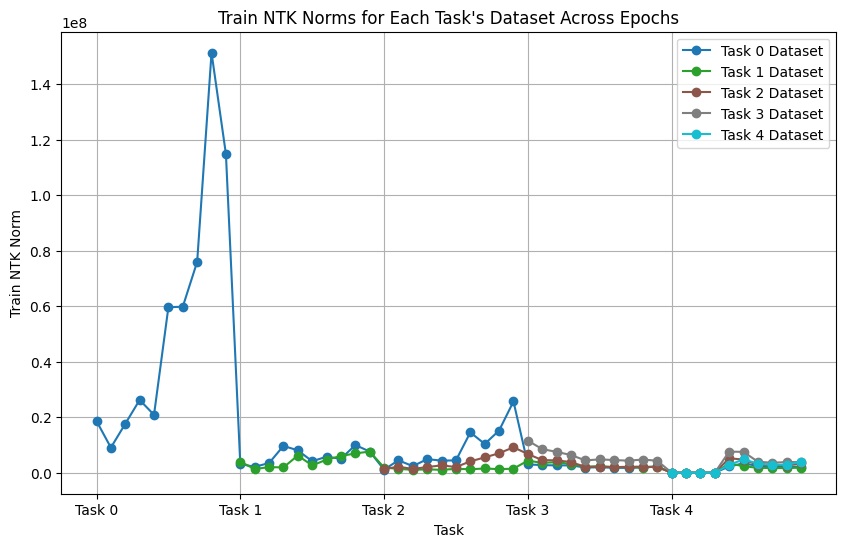

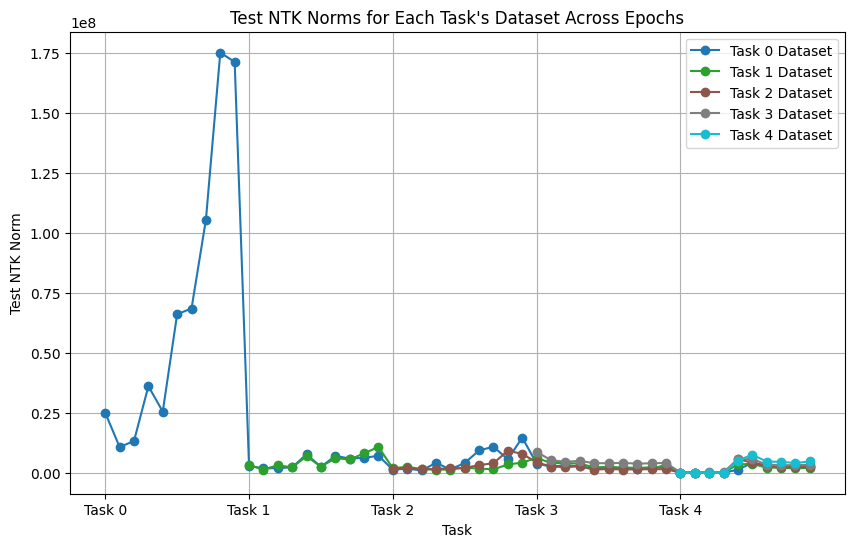

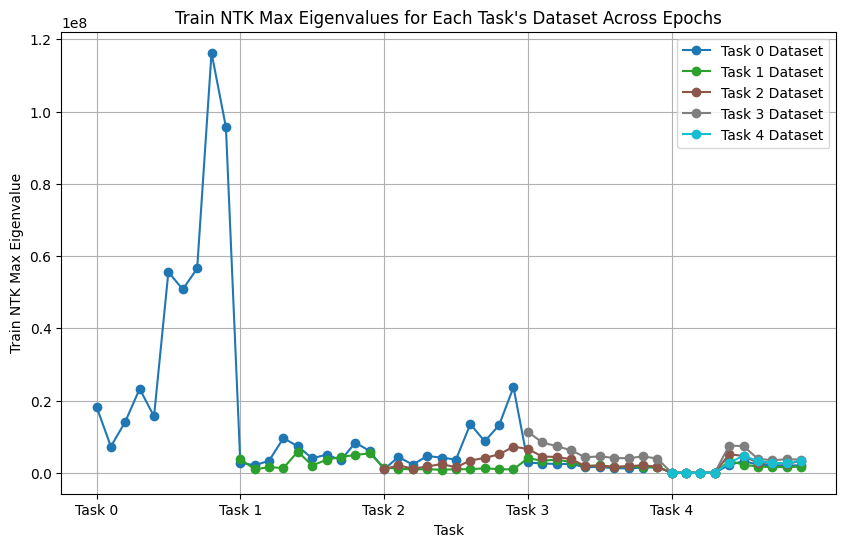

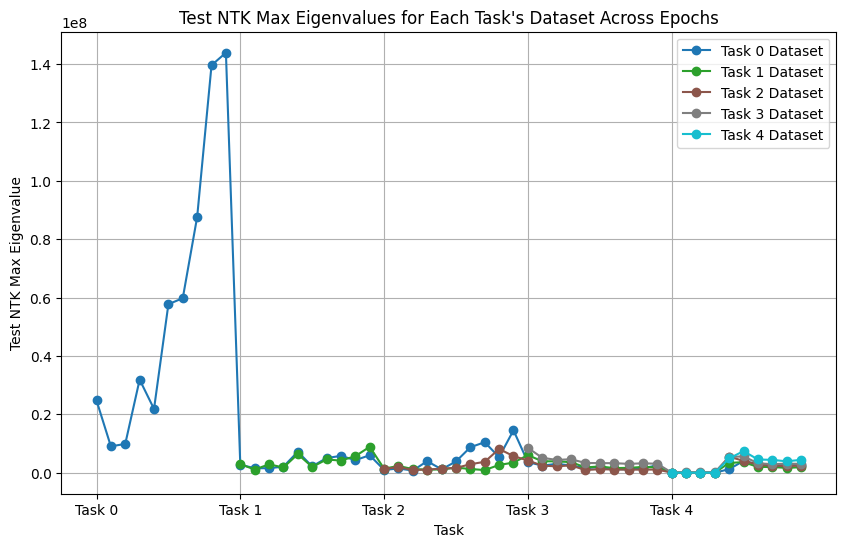

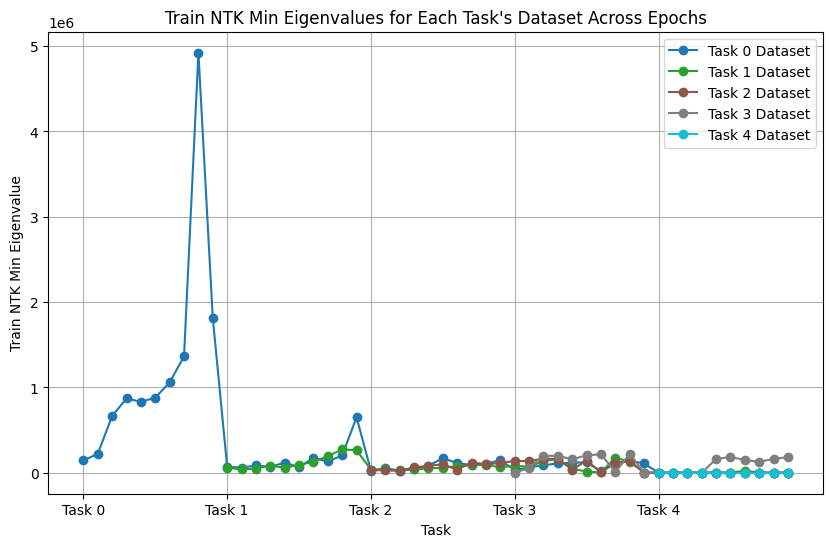

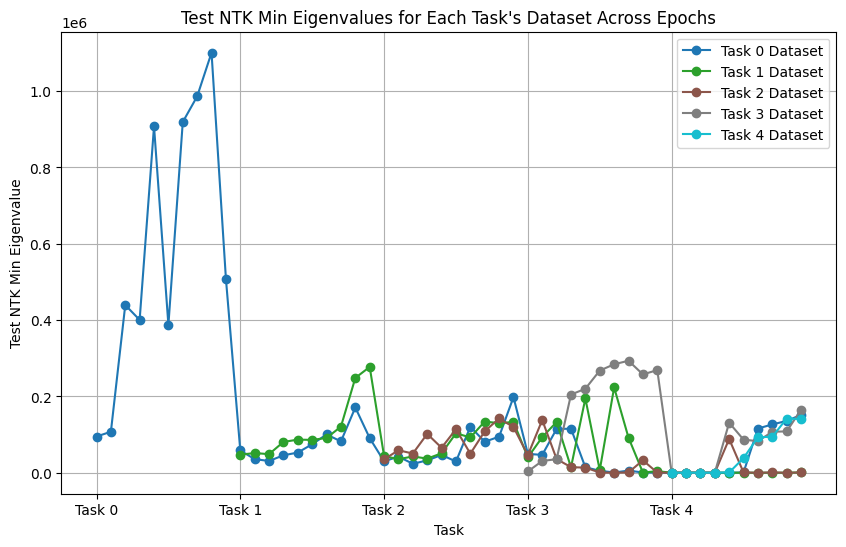

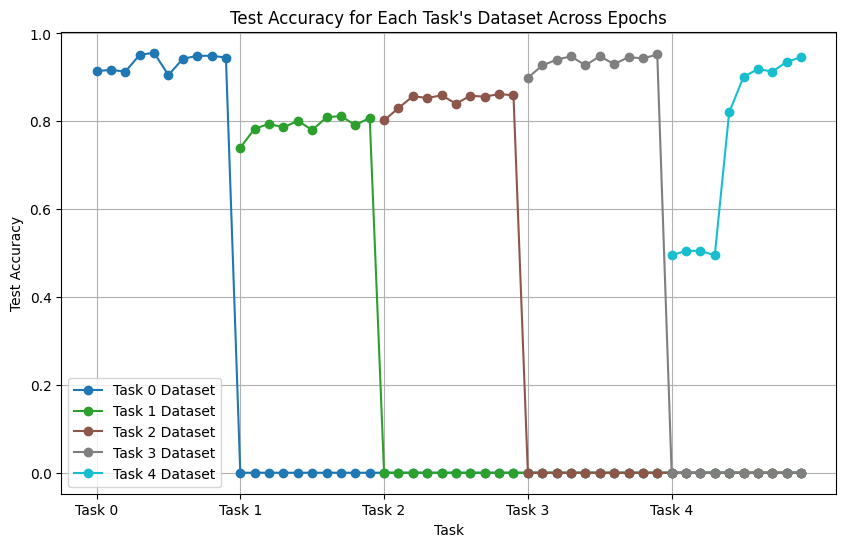


=== Task 1 ===
Epoch 1, Train Loss: 0.3741, Val Loss: 0.2628, Train Accuracy: 0.8444, Val Accuracy: 0.8830
Accuracy on Task 1 at Epoch 1: 0.8830
Epoch 2, Train Loss: 0.2178, Val Loss: 0.2403, Train Accuracy: 0.9142, Val Accuracy: 0.8920
Accuracy on Task 1 at Epoch 2: 0.8920
Epoch 3, Train Loss: 0.1560, Val Loss: 0.1784, Train Accuracy: 0.9376, Val Accuracy: 0.9380
Accuracy on Task 1 at Epoch 3: 0.9380
Epoch 4, Train Loss: 0.1348, Val Loss: 0.1488, Train Accuracy: 0.9473, Val Accuracy: 0.9490
Accuracy on Task 1 at Epoch 4: 0.9490
Epoch 5, Train Loss: 0.0985, Val Loss: 0.1244, Train Accuracy: 0.9623, Val Accuracy: 0.9530
Accuracy on Task 1 at Epoch 5: 0.9530
Epoch 6, Train Loss: 0.0676, Val Loss: 0.1503, Train Accuracy: 0.9746, Val Accuracy: 0.9430
Accuracy on Task 1 at Epoch 6: 0.9430
Epoch 7, Train Loss: 0.0616, Val Loss: 0.1549, Train Accuracy: 0.9782, Val Accuracy: 0.9460
Accuracy on Task 1 at Epoch 7: 0.9460
Epoch 8, Train Loss: 0.0480, Val Loss: 0.1697, Train Accuracy: 0.9827, Val

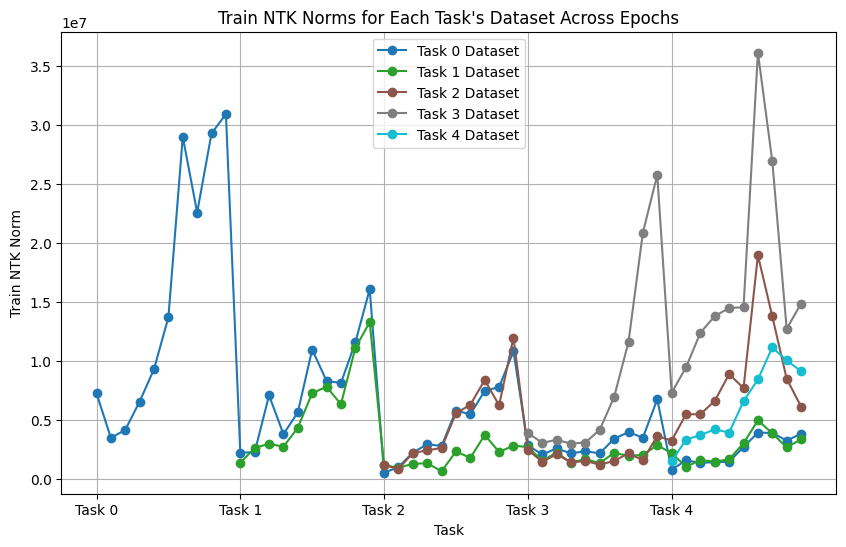

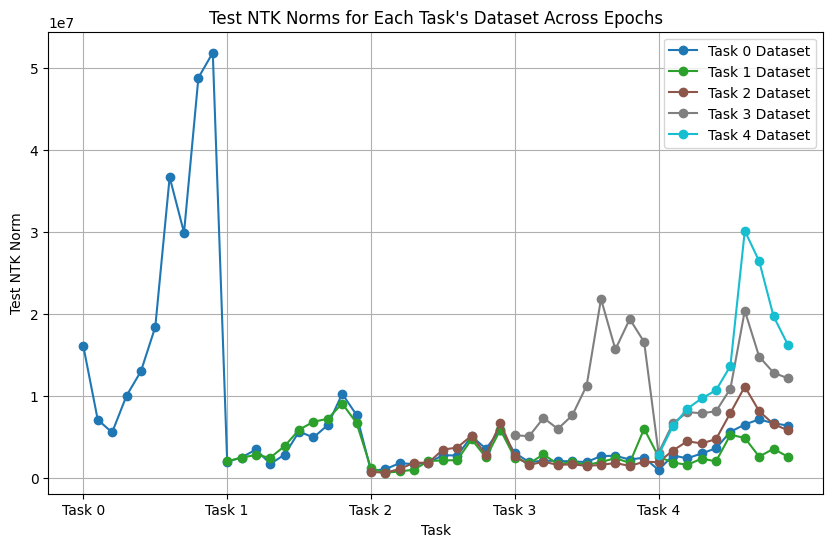

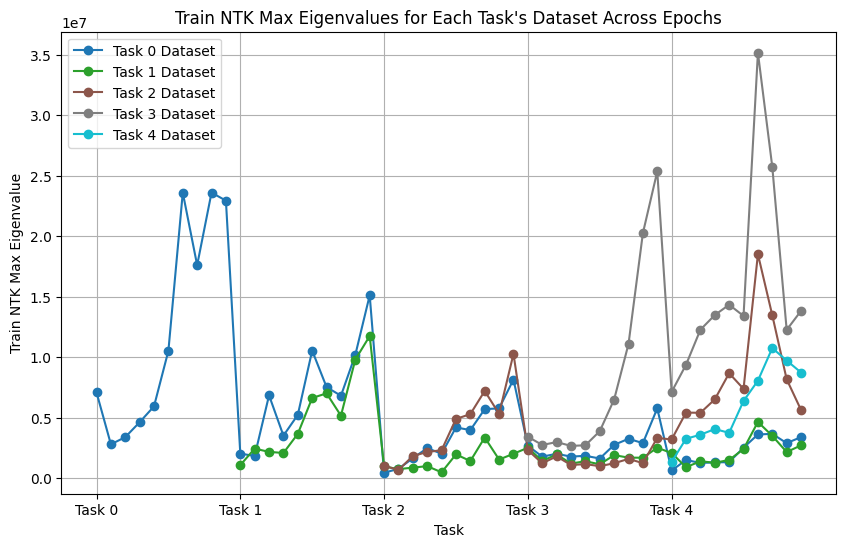

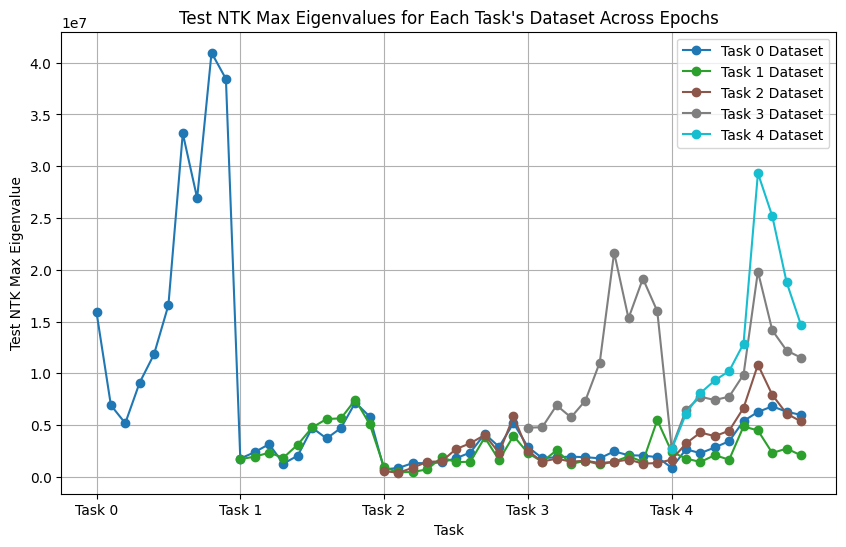

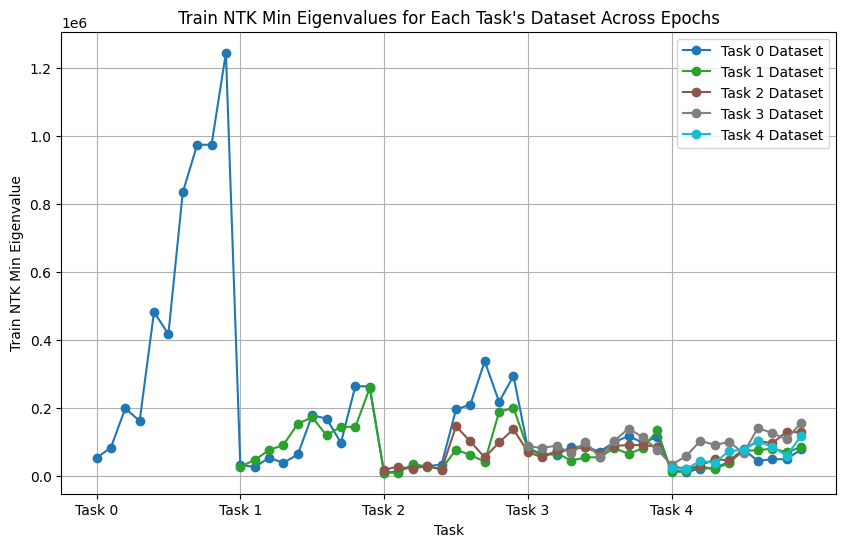

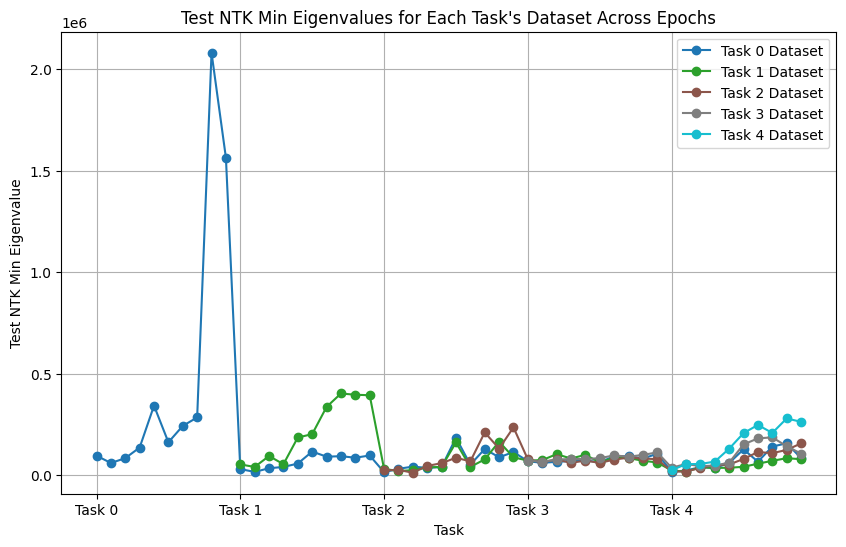

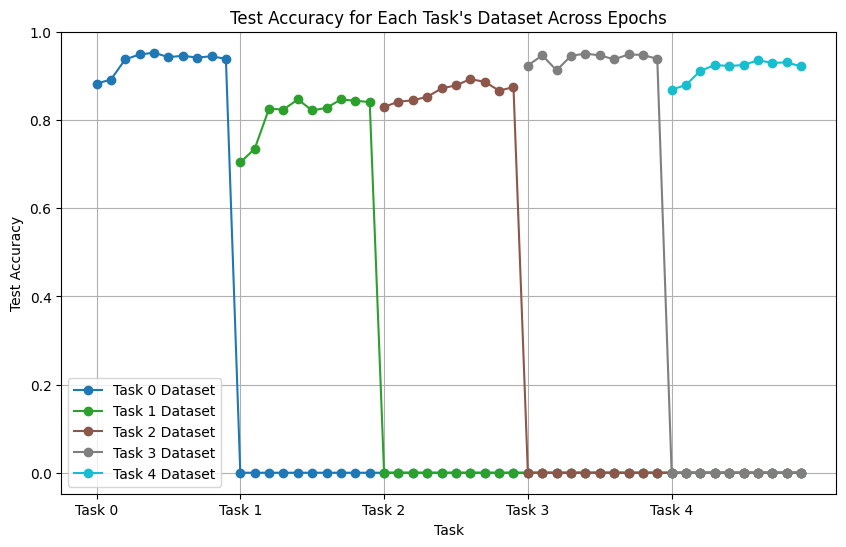


=== Task 1 ===
Epoch 1, Train Loss: 0.4336, Val Loss: 0.3668, Train Accuracy: 0.8348, Val Accuracy: 0.8380
Accuracy on Task 1 at Epoch 1: 0.8380
Epoch 2, Train Loss: 0.2380, Val Loss: 0.2128, Train Accuracy: 0.9033, Val Accuracy: 0.9150
Accuracy on Task 1 at Epoch 2: 0.9150
Epoch 3, Train Loss: 0.1725, Val Loss: 0.1738, Train Accuracy: 0.9359, Val Accuracy: 0.9300
Accuracy on Task 1 at Epoch 3: 0.9300
Epoch 4, Train Loss: 0.1360, Val Loss: 0.1716, Train Accuracy: 0.9491, Val Accuracy: 0.9310
Accuracy on Task 1 at Epoch 4: 0.9310
Epoch 5, Train Loss: 0.1109, Val Loss: 0.1346, Train Accuracy: 0.9576, Val Accuracy: 0.9510
Accuracy on Task 1 at Epoch 5: 0.9510
Epoch 6, Train Loss: 0.0934, Val Loss: 0.1563, Train Accuracy: 0.9669, Val Accuracy: 0.9510
Accuracy on Task 1 at Epoch 6: 0.9510
Epoch 7, Train Loss: 0.0749, Val Loss: 0.1681, Train Accuracy: 0.9713, Val Accuracy: 0.9490
Accuracy on Task 1 at Epoch 7: 0.9490
Epoch 8, Train Loss: 0.0726, Val Loss: 0.1932, Train Accuracy: 0.9740, Val

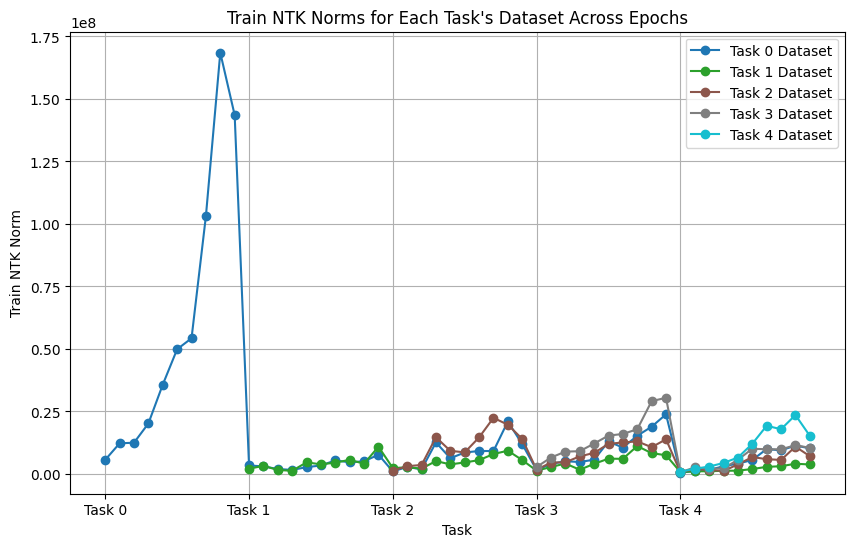

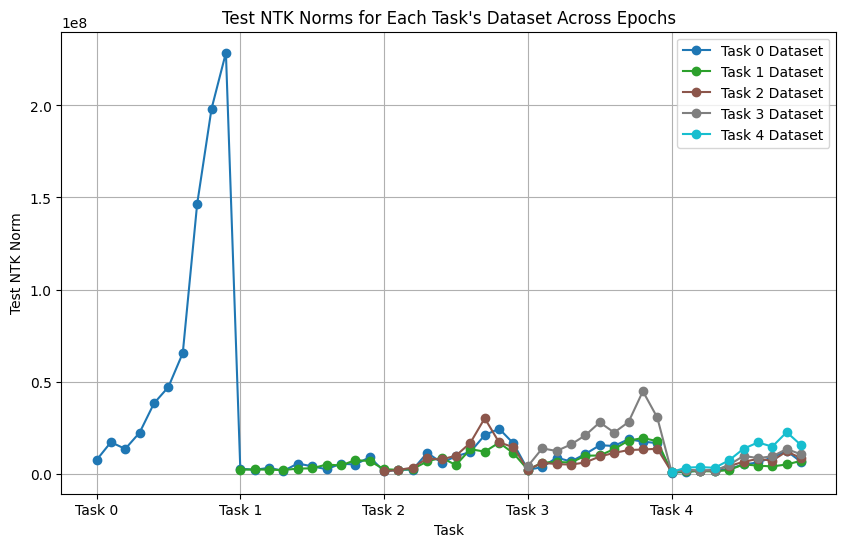

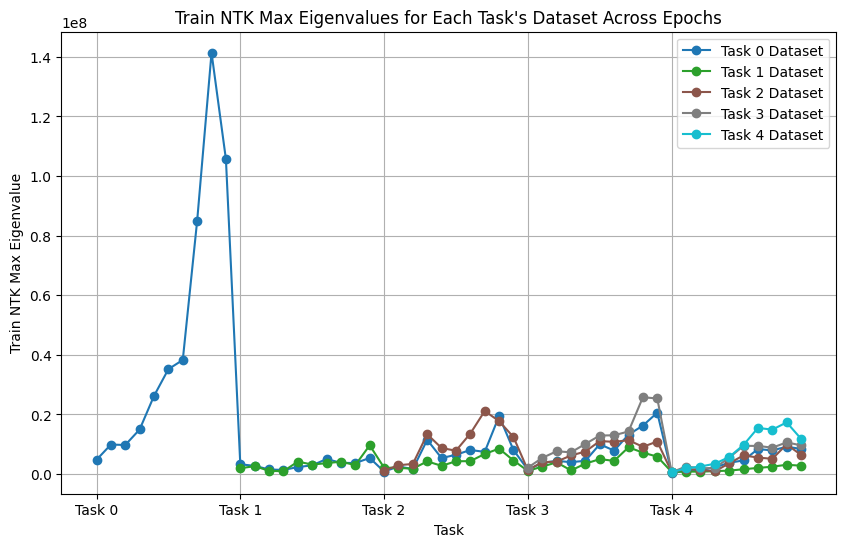

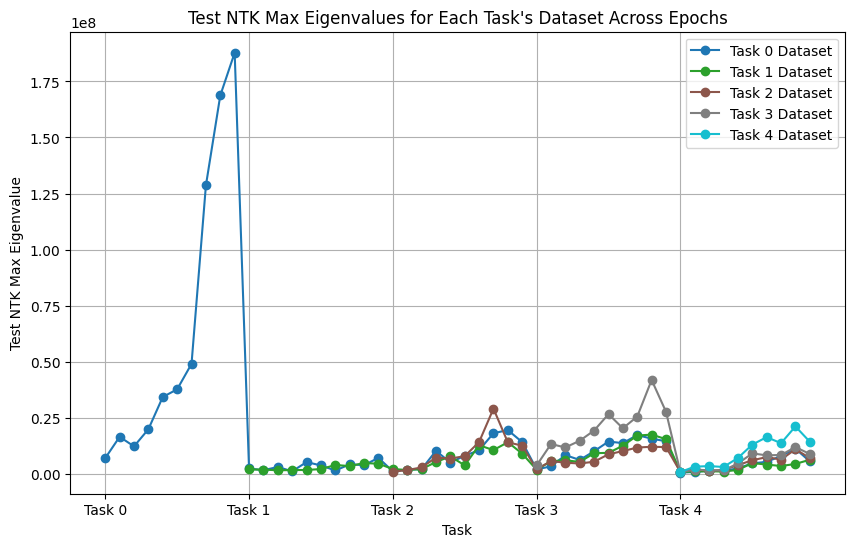

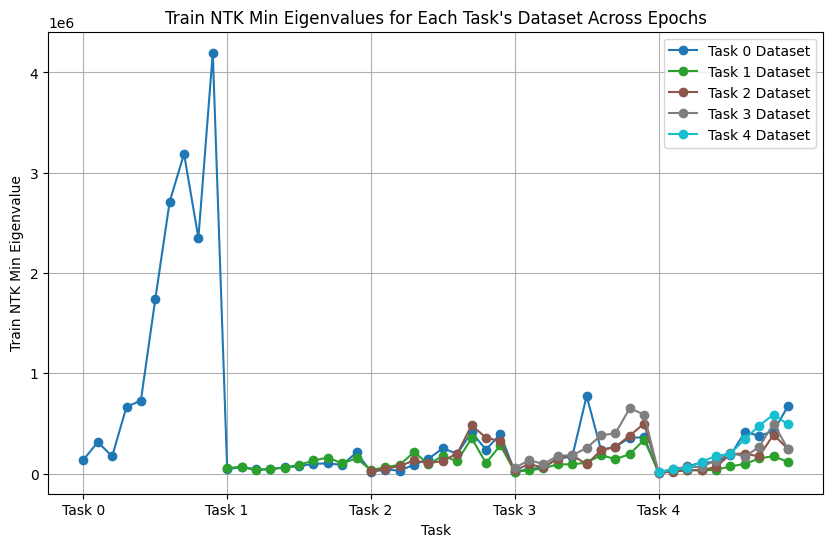

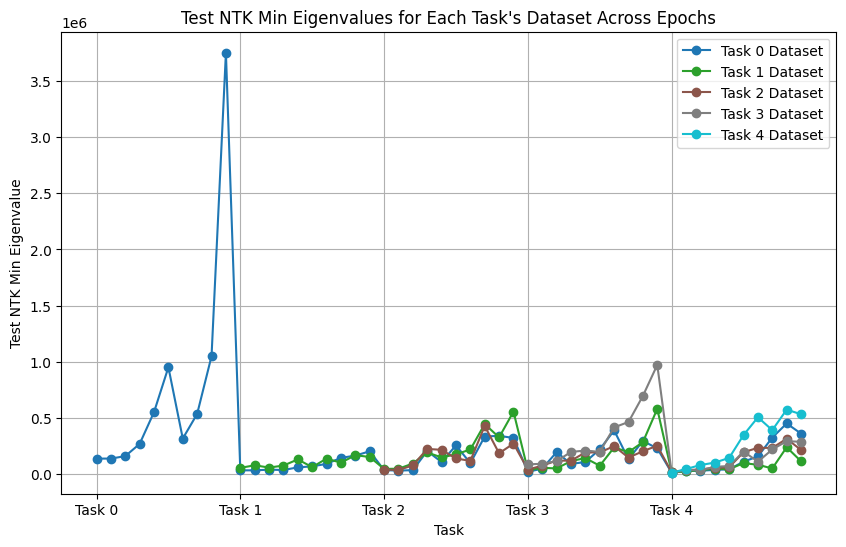

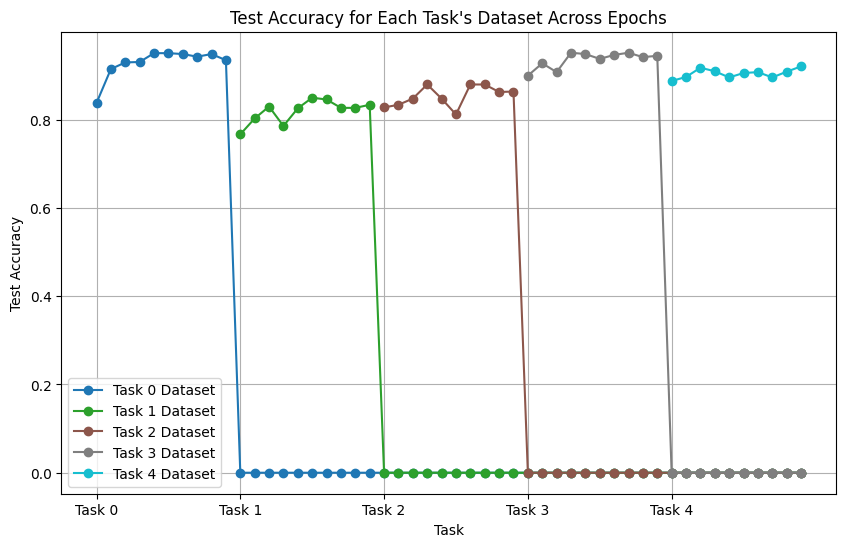


=== Task 1 ===
Epoch 1, Train Loss: 0.5892, Val Loss: 0.2530, Train Accuracy: 0.8367, Val Accuracy: 0.8930
Accuracy on Task 1 at Epoch 1: 0.8930
Epoch 2, Train Loss: 0.2513, Val Loss: 0.2268, Train Accuracy: 0.8986, Val Accuracy: 0.9010
Accuracy on Task 1 at Epoch 2: 0.9010
Epoch 3, Train Loss: 0.1841, Val Loss: 0.1686, Train Accuracy: 0.9322, Val Accuracy: 0.9340
Accuracy on Task 1 at Epoch 3: 0.9340
Epoch 4, Train Loss: 0.1421, Val Loss: 0.1509, Train Accuracy: 0.9464, Val Accuracy: 0.9400
Accuracy on Task 1 at Epoch 4: 0.9400
Epoch 5, Train Loss: 0.1172, Val Loss: 0.1621, Train Accuracy: 0.9573, Val Accuracy: 0.9460
Accuracy on Task 1 at Epoch 5: 0.9460
Epoch 6, Train Loss: 0.0935, Val Loss: 0.1816, Train Accuracy: 0.9646, Val Accuracy: 0.9370
Accuracy on Task 1 at Epoch 6: 0.9370
Epoch 7, Train Loss: 0.0660, Val Loss: 0.1519, Train Accuracy: 0.9762, Val Accuracy: 0.9510
Accuracy on Task 1 at Epoch 7: 0.9510
Epoch 8, Train Loss: 0.0636, Val Loss: 0.2492, Train Accuracy: 0.9782, Val

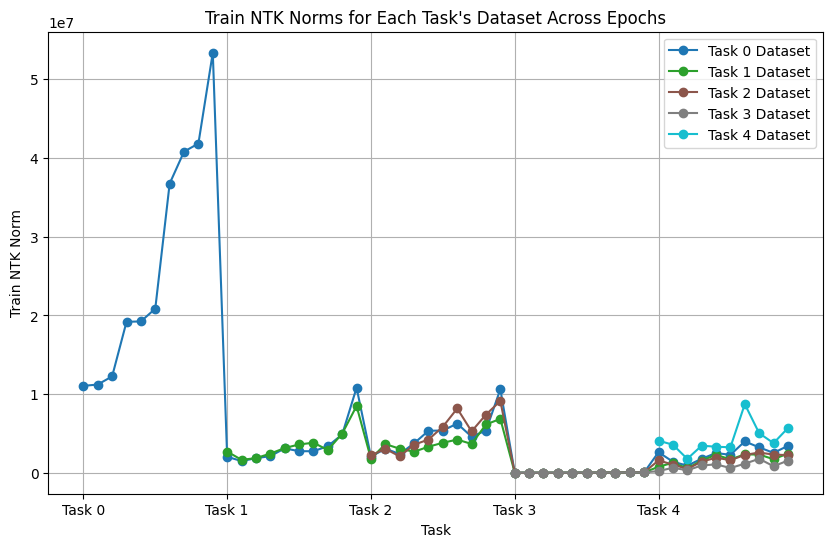

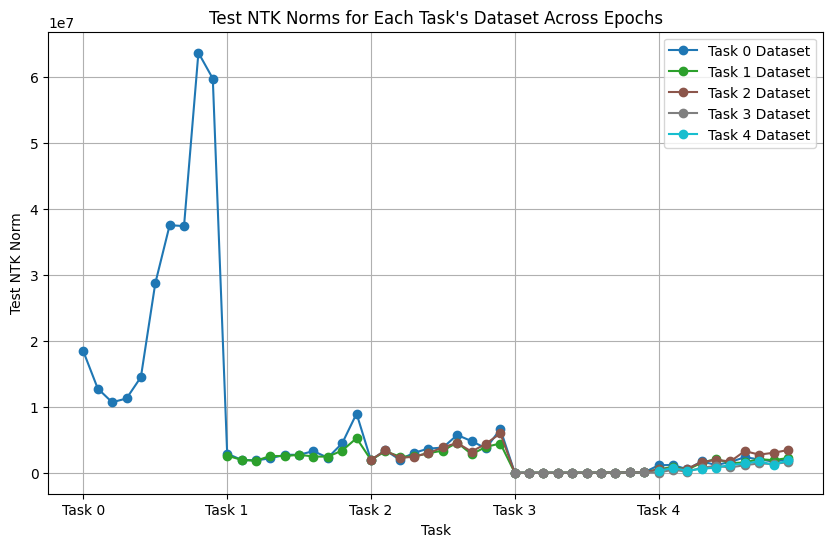

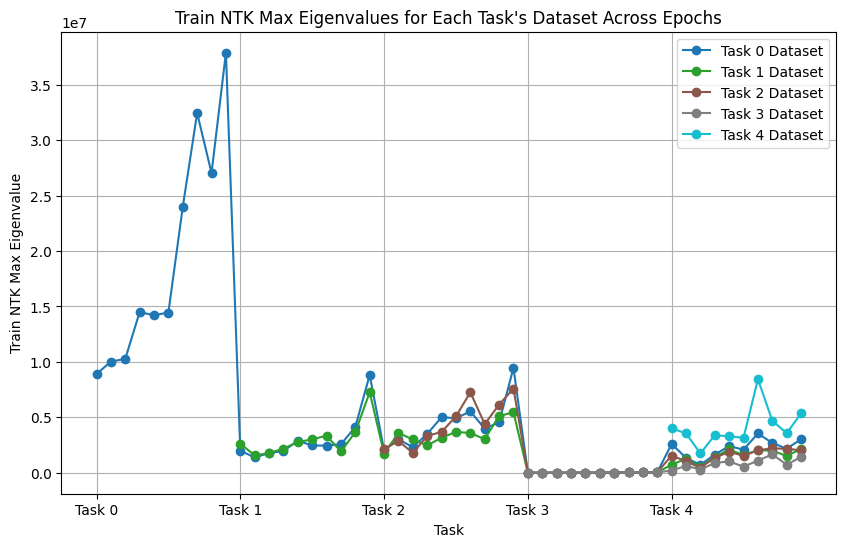

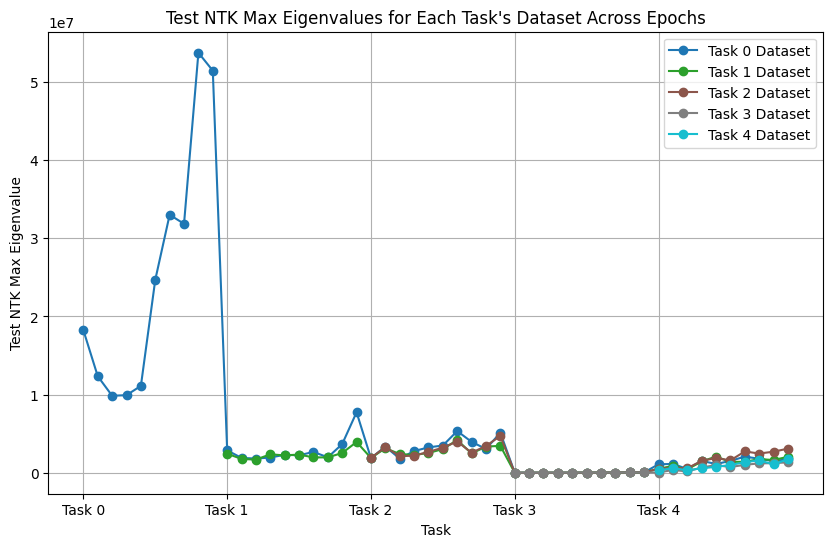

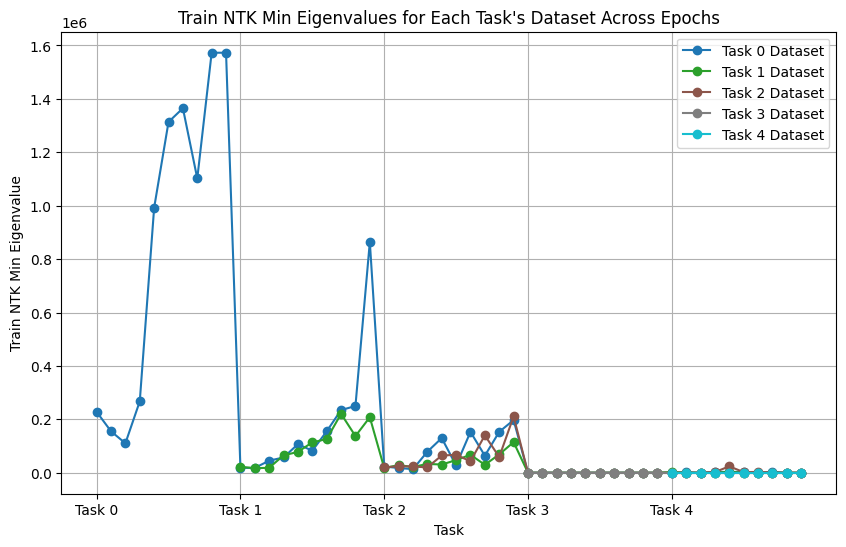

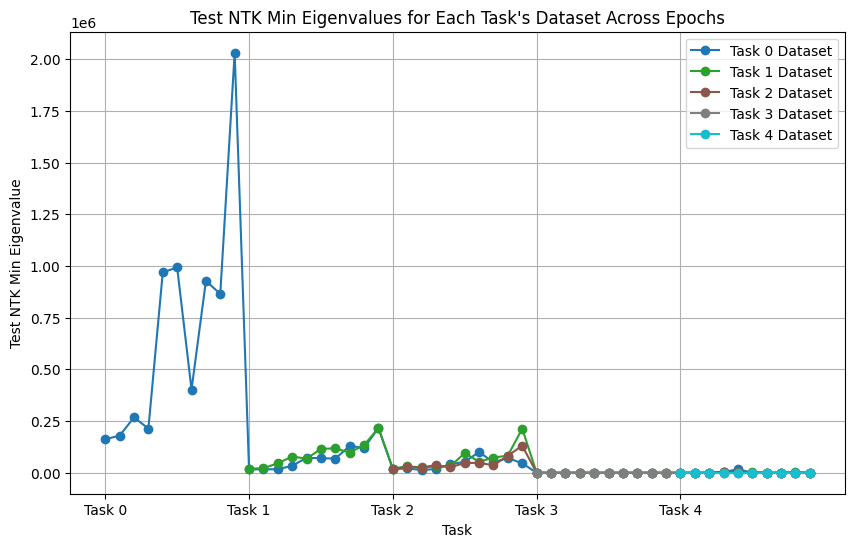

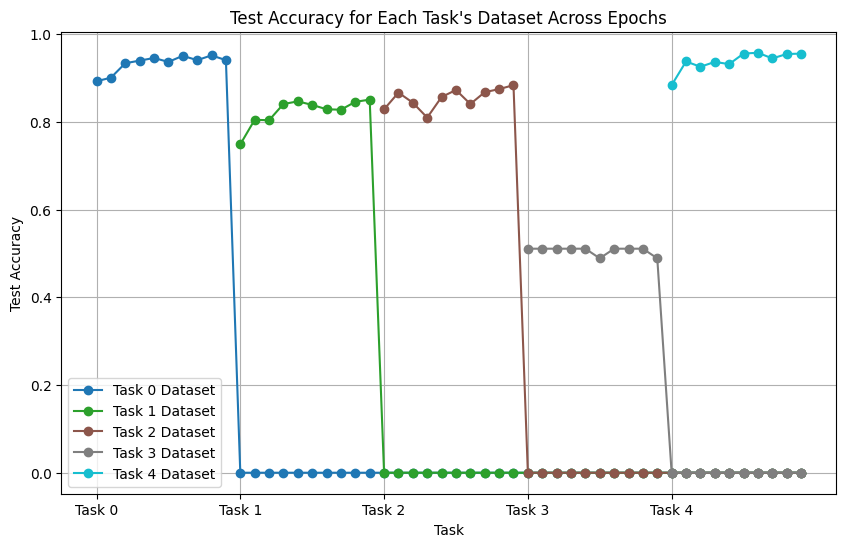

In [4]:
layer_sizes_list = [
    [3,1000,10,32],
    [3,1000,10,64],
    [3,5000,10,32],
    [3,5000,10,64],
]

metrics = {
    "CNN":{
        "CIFAR10": {
            "10-10-10": {
                "1000_32": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "1000_64": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "5000_32": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "5000_64": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None}
            }
        }
    }
}

for layer_sizes in layer_sizes_list:
    width = layer_sizes[1]  
    input_dim, hidden_dim, output_dim, channel = layer_sizes
    model = CNN(input_dim, hidden_dim, output_dim, channel ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs_per_task = 10

    train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate(model, epochs_per_task)

    metrics["CNN"]["CIFAR10"]["10-10-10"][str(width)] = {
        "train_ntk_matrices": train_ntk_matrices,
        "test_ntk_matrices": test_ntk_matrices,
        "task_accuracies": task_accuracies
    }
    
import pickle 
with open("cnn_cifar10_10_10_10epo_cuda.pkl", "wb") as file:
    pickle.dump(metrics, file)